# **Traffic Project**
> *Data on US traffic accidents and fatalities in 2004 from the US Department of Transportation. The data covers all 50 states and the District of Columbia.*

**Obiettivo:** Realizzare un algoritmo di classificazione binaria che stabilisca se in uno stato ci possa essere un alto o un basso rischio di incidenti, mediante l'utilizzo delle feature e dei campioni disponibili.

## *NOTE*

---

- **Census ID:** Feature superflua. Possiamo rimuoverla;
- **Numero di campioni:** 50 stati più la capitale;
- **Training + Validation:** 41 campioni di cui 10 per la Validation;
- **External testing:** 10 campioni;

---

|                        | Description                                     |
| ---------------------- | ----------------------------------------------- |
| **Task**               | Classificazione binaria con soglia              |
| **Learning method**    | Supervisionato                                  |
| **Classe/Label**       | Alto richio (1) - Basso rischio (0)             |
| **Performance metric** | Accuratezza = (TP+TN)/(P+N)                     |
| **Pattern/Sample**     | Insieme di valori del singolo stato (riga)      |
| **Entity**             | Singolo stato degli US                          |
| **Threshold cutoff**   | Soglia da stimare per suddividere le due classi |

---

## *TO DO*
- [x] Caricare il dataset
- [x] Definire il **cutoff** per la classificazione
  - [x] Trovare il miglior **fit** per la distribuzione relativa alla densità di morti per 100K abitanti
  - [ ] Sistemare codice
  - [x] Scegliere come cutoff il punto successivo al cambio di concavità
  - [x] Rimuovere le feature utilizzate per determinare il cutoff
- [x] Provare con e senza **PCA**
  - [x] Trovare la **matrice di correlazione**
  - [x] Ricavare **autovalori** e **autovettori** (gli autovalori corrispondono alle varianze delle componenti)
  - [x] Ordinare gli autovalori e selezionare quelli principali
  - [x] Determinare le **componenti principali** e costruire il nuovo dataset
- [x] Suddivisione in fold per la Corss-Validation
- [x] Training e Validation con **SVM**
  - [x] Studiare al variare di K (eventualmente anche del kernel)
  - [x] Ricavare le varie metriche di performance
  - [x] Acquisire N volte i risultati per lo stesso K e mediare le metriche per vedere effettivamente quale K possa essere il migliore?
- [x] Training e Validation con **Random Forest**
  - [x] Studiare al variare di K e degli alberi
- [x] ROC e AUC
- [x] Salvare i modelli e testarli sul dataset esterno
---
- [ ] Ensemble (faccio votare più modelli per il risultato sull'external testing)
- [ ] Valore medio e deviazione standard delle metriche e delle feature (per anche gli outlier)
- [ ] Outlier
  - [ ] Testare togliendo gli outlier
- [ ] Statistical test (aggiungere tabelle o parti nel grafico per evidenziare il migliore)
- [ ] Unbalanced training
- [ ] Feature augmentation
- [x] Confusion matrix
- [x] Testing esterno
---

## G-Drive disk mount

In [ ]:
from google.colab import drive, output
output.enable_custom_widget_manager()
drive.mount('/content/drive')

path = '/content/drive/MyDrive/ML-Colab/'
nameFolder = 'TrafficProject'

Mounted at /content/drive


In [ ]:
cd {path}{nameFolder}

/content/drive/.shortcut-targets-by-id/1kwncC2iWlZKczIwcO5MOHHofMGlm23VK/ML-Colab/TrafficProject


## Packages

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/ML-Colab/colab-venv/lib/python3.10/site-packages")
sys.path.append("/content/drive/MyDrive/ML-Colab")
from myClassROC import ABC123

%matplotlib widget
import numpy as np
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import poisson, lognorm
from scipy.optimize import curve_fit
import pickle
from jupyprint import jupyprint, arraytex

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import KFold # divide il set di dati in k fold (sottogruppi) di dimensioni uguali.
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc

## Load dataset


In [ ]:
file_mat = loadmat('accidents.mat')
print(file_mat['datasources'])

[[array(['SOURCES: U.S. Department of Transportation, National Highway Traffic Safety Administration, Traffic Safety Facts 2004 Early Edition, Washington, DC: 2005, available at http://www-nrd.nhtsa.dot.gov/pdf/nrd-30/NCSA/TSFAnn/ TSF2004EarlyEdition.pdf as of Dec. 15, 2005; U.S. Department of Transportation, Federal Highway Administration, Highway Statistics 2004, Washington, DC: forthcoming. (Table 2-1:  Highway Traffic Fatalities and Fatality Rates: 2004)'],
        dtype='<U452')                                                                                                                                                                                                                                                                                                                                                                                                                                                           ]
 [array(['SOURCES: U.S. Department of Transportation, National High

## Dataset description:
*Data on US traffic accidents and fatalities in 2004 from the US Department of Transportation. The data covers all 50 states and the District of Columbia.*

| Nome dataset  | Descrizione                                                       |
| ------------- | ----------------------------------------------------------------- |
| *datasources* | Fonti                                                             |
| *hwyheaders*  | Nomi delle features                                               |
| *hwydata*     | Valori delle features per stato (righe: stati, colonne: features) |
| *ushwydata*   | Valori delle features complessivi per gli Stati Uniti             |
| *hwycol*      | Numero di features (colonne)                                      |
| *hwyrows*     | Numero di stati compresa District of Columbia (righe)             |
| *statelabel*  | Etichette per le righe di *hwydata* (Nome degli stati)            |
| *uslabel*     | Etichette per le righe di *ushwydata* (United States)             |
| *hwyidx*      | ???                                                               |

## Visualizzazione intero dataset

In [ ]:
jupyprint(pd.DataFrame(file_mat['hwydata'], index = [str(array[0][0]) for array in file_mat['statelabel']], columns = [i[0] for i in file_mat['hwyheaders'][0]] ))

Census ID  Centroid Longitude  Centroid Latitude  \
Wyoming                    56.0         -107.555625          43.032664   
District of Columbia       11.0          -77.026928          38.892064   
Vermont                    50.0          -72.556496          44.043498   
Alaska                      2.0         -152.459342          64.609656   
North Dakota               38.0          -99.499793          47.469117   
South Dakota               46.0          -99.678970          44.272030   
Delaware                   10.0          -75.494156          39.107074   
Montana                    30.0         -110.576261          46.867085   
Rhode Island               44.0          -71.433651          41.588663   
Hawaii                     15.0         -154.525892          21.045779   
New Hampshire              33.0          -71.559103          43.907990   
Maine                      23.0          -69.081113          44.885791   
Idaho                      16.0         -114.619934          45.010490   
Nebraska                   31.0          -99.434739          41.504492   
West Virginia              54.0          -80.274868          38.850586   
New Mexico                 35.0         -106.175514          34.291490   
Nevada                     32.0         -116.399879          39.176530   
Utah                       49.0         -111.638517          39.414291   
Arkansas                    5.0          -91.886096          34.834952   
Kansas                     20.0          -98.210526          38.563167   
Mississippi                28.0          -90.057733          32.484248   
Iowa                       19.0          -93.762335          42.132789   
Connecticut                 9.0          -72.762720          41.510585   
Oregon                     41.0         -120.556309          44.163728   
Oklahoma                   40.0          -97.978271          35.422612   
South Carolina             45.0          -81.245037          33.810122   
Kentucky                   21.0          -85.666739          37.567621   
Colorado                    8.0         -105.543955          39.029532   
Alabama                     1.0          -86.920600          32.282672   
Louisiana                  22.0          -91.336153          30.714212   
Minnesota                  27.0          -94.101406          46.776507   
Arizona                     4.0         -112.070500          34.345101   
Maryland                   24.0          -77.028850          39.047751   
Wisconsin                  55.0          -89.749798          44.982996   
Missouri                   29.0          -92.230655          38.311173   
Tennessee                  47.0          -86.208860          35.896927   
Washington                 53.0         -121.422916          47.590362   
Indiana                    18.0          -86.577065          39.448159   
Massachusetts              25.0          -71.141290          41.994891   
Virginia                   51.0          -78.949416          37.546013   
North Carolina             37.0          -79.052731          35.627245   
Georgia                    13.0          -83.086436          32.580268   
New Jersey                 34.0          -74.716337          40.172888   
Michigan                   26.0          -85.908551          45.199633   
Ohio                       39.0          -82.662996          40.217482   
Pennsylvania               42.0          -77.503957          40.937516   
Illinois                   17.0          -89.198000          39.742374   
Florida                    12.0          -82.848294          28.391421   
New York                   36.0          -75.282885          42.537880   
Texas                      48.0          -99.209698          30.515779   
California                  6.0         -119.663274          36.822283   

                      Traffic fatalities  Licensed drivers (thousands)  \
Wyoming                            164.0                       380.180   
District of Columbia     

## Catalogazione dataset

In [ ]:
data = np.delete(file_mat['hwydata'], 0, axis=1) # Elimina i dati della prima feature perché inutile
features = np.delete(file_mat['hwyheaders'], 0, axis=1) # Elimina l'etichetta della prima feature perché inutile

# data = file_mat['hwydata']
# features = file_mat['hwyheaders']

features = [i[0] for i in features[0]]

state_names = np.array([str(array[0][0]) for array in file_mat['statelabel']])

# Per rendere stati esterni casuali
#index = np.arange(51)
#np.random.shuffle(index)
#idx_ext = index[:10]
#idx_int = index[10:]

idx_ext = [2, 44, 39, 49, 27, 46, 40, 25, 21, 5]
idx_int = [42, 32, 18, 38, 37, 3, 8, 12, 34, 7, 24, 36, 22, 41, 47, 28, 14, 23, 31, 33, 35, 19, 17, 10, 26, 9, 0, 6, 45, 15, 1, 43, 48, 11, 20, 16, 50, 30, 13, 29, 4]

data_ext = data[idx_ext]
data_int = data[idx_int]

state_names_ext = state_names[idx_ext]
state_names_int = state_names[idx_int]

print('Samples:', state_names.tolist())
print('Samples_int:', state_names_int)
print('Samples_ext:', state_names_ext)
print('Features:', features)


density_int = [data_int[:,features.index('Traffic fatalities')] * 100000 / data_int[:,features.index('Total Population')],
               data_int[:,features.index('Fatalities per 100K licensed drivers')],
               data_int[:,features.index('Fatalities per 100K registered vehicles')]
              ]

density_ext = [data_ext[:,features.index('Traffic fatalities')] * 100000 / data_ext[:,features.index('Total Population')],
               data_ext[:,features.index('Fatalities per 100K licensed drivers')],
               data_ext[:,features.index('Fatalities per 100K registered vehicles')]
              ]

# jupyprint(pd.DataFrame(data, index = [str(array[0][0]) for array in file_mat['statelabel']], columns = features ))

Samples: ['Wyoming', 'District of Columbia', 'Vermont', 'Alaska', 'North Dakota', 'South Dakota', 'Delaware', 'Montana', 'Rhode Island', 'Hawaii', 'New Hampshire', 'Maine', 'Idaho', 'Nebraska', 'West Virginia', 'New Mexico', 'Nevada', 'Utah', 'Arkansas', 'Kansas', 'Mississippi', 'Iowa', 'Connecticut', 'Oregon', 'Oklahoma', 'South Carolina', 'Kentucky', 'Colorado', 'Alabama', 'Louisiana', 'Minnesota', 'Arizona', 'Maryland', 'Wisconsin', 'Missouri', 'Tennessee', 'Washington', 'Indiana', 'Massachusetts', 'Virginia', 'North Carolina', 'Georgia', 'New Jersey', 'Michigan', 'Ohio', 'Pennsylvania', 'Illinois', 'Florida', 'New York', 'Texas', 'California']
Samples_int: ['New Jersey' 'Maryland' 'Arkansas' 'Massachusetts' 'Indiana' 'Alaska'
 'Rhode Island' 'Idaho' 'Missouri' 'Montana' 'Oklahoma' 'Washington'
 'Connecticut' 'Georgia' 'Florida' 'Alabama' 'West Virginia' 'Oregon'
 'Arizona' 'Wisconsin' 'Tennessee' 'Kansas' 'Utah' 'New Hampshire'
 'Kentucky' 'Hawaii' 'Wyoming' 'Delaware' 'Pennsylvani

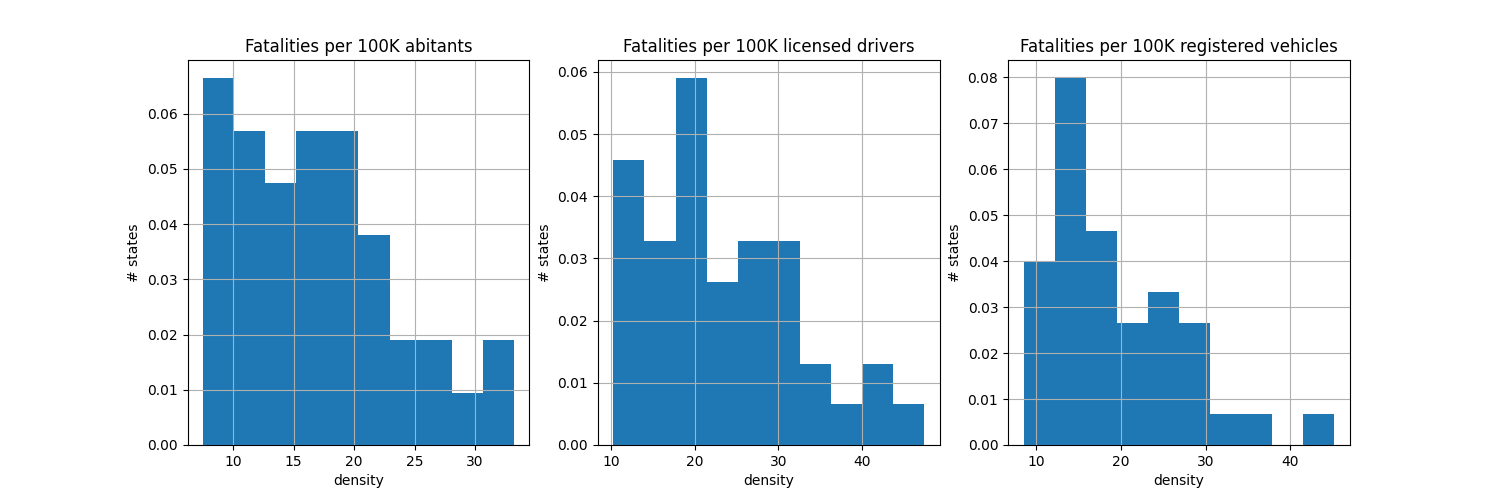

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(density_int[0], density=True)
# plt.plot(x, pdf_fit[0], 'r-', label='Curva Lognormale Fittata')
plt.title('Fatalities per 100K abitants')
plt.ylabel('# states')
plt.xlabel('density')
plt.grid()

plt.subplot(1, 3, 2)
plt.hist(density_int[1], density=True)
# plt.plot(x, pdf_fit[1], 'r-', label='Curva Lognormale Fittata')
plt.title('Fatalities per 100K licensed drivers')
plt.ylabel('# states')
plt.xlabel('density')
plt.grid()

plt.subplot(1, 3, 3)
plt.hist(density_int[2], density=True)
# plt.plot(x, pdf_fit[2], 'r-', label='Curva Lognormale Fittata')
plt.title('Fatalities per 100K registered vehicles')
plt.ylabel('# states')
plt.xlabel('density')
plt.grid()

plt.show()

## Prova fit con lognorm

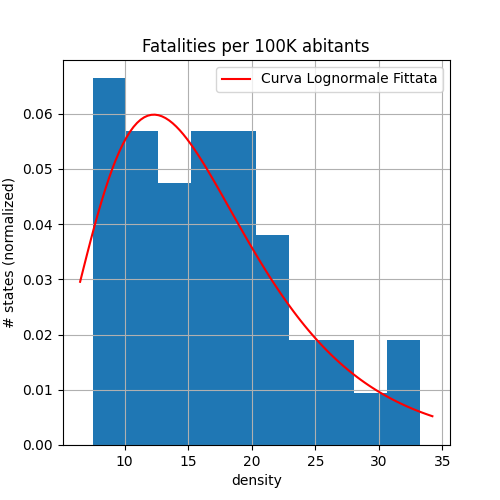

In [ ]:
density = density_int[0]

frequencies, bin_edges = np.histogram(density, bins=10)  # Modifica il numero di bin se necessario

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # punti medi dei bin

# Definisci la funzione lognormale da fittare ai dati
def lognorm_func(x, sigma, loc, scale):
  return frequencies.sum() * np.diff(bin_edges)[0] * lognorm.pdf(x, sigma, loc=loc, scale=scale)  # Il termine seguente "frequencies.sum() * np.diff(bin_edges)[0]" corrisponde all'area dell'istogramma, serve per riscalare la pdf in modo da fittarla con i nostri dati

# Fittare la curva ai dati
popt, pcov = curve_fit(lognorm_func, bin_centers, frequencies)

# Parametri ottimizzati
sigma_fit, loc_fit, scale_fit = popt

# Crea una distribuzione lognormale con i parametri fittati
x = np.linspace(min(density)-1, max(density)+1, 100)
pdf_fit = lognorm.pdf(x, sigma_fit, loc=loc_fit, scale=scale_fit)

# Plot dei dati e della curva fittata
plt.figure(figsize=(5, 5))

plt.subplot()

plt.hist(density, density=True)
plt.plot(x, pdf_fit, 'r-', label='Curva Lognormale Fittata')
plt.legend()
plt.grid()
plt.xlabel('density')
plt.ylabel('# states (normalized)')
plt.title('Fatalities per 100K abitants')
plt.show()


In [1]:
# Calcolo della seconda derivata
def second_derivative(func, x):
    h = 0.0001
    return (func(x - 2*h) - 2 * func(x - h) + func(x)) / (h ** 2)

# Calcolo dei punti in cui la concavità cambia
x_values = np.linspace(int(min(density_int[0])), int(max(density_int[0])),)  # range di valori di x da esaminare
second_derivatives = second_derivative(lambda x: lognorm_func(x, sigma_fit, loc_fit, scale_fit), x_values)
sign_changes = np.where(np.diff(np.sign(second_derivatives)))

# Stampa dei punti in cui la concavità cambia
print("Punti in cui la concavità cambia:")
for index in sign_changes:
    print("x =", x_values[index])

NameError: name 'np' is not defined

## Creazione label e rimozione delle feature usate per determinare il cutoff

In [ ]:
# Soglia densità per 100k abitanti (a sentimento(cambio segno derivata seconda))
cutoff = x_values[sign_changes[0][-1]]

labels_int = np.zeros(len(density_int[0]))
labels_int[density_int[0] > cutoff] = 1

labels_ext = np.zeros(len(density_ext[0]))
labels_ext[density_ext[0] > cutoff] = 1

# data_int = np.delete(data_int, features.index('Fatalities per 100K registered vehicles'), axis=1) # Elimina i dati degli incidenti perchè usati per la label
# data_ext = np.delete(data_ext, features.index('Fatalities per 100K registered vehicles'), axis=1) #
# del features[features.index('Fatalities per 100K registered vehicles')]                           #

data_int = np.delete(data_int, features.index('Traffic fatalities'), axis=1) # Elimina i dati degli incidenti perchè usati per la label
data_ext = np.delete(data_ext, features.index('Traffic fatalities'), axis=1) #
del features[features.index('Traffic fatalities')]                           #

data_int = np.delete(data_int, features.index('Total Population'), axis=1) # Elimina i dati della popolazione totale perchè usati per la label
data_ext = np.delete(data_ext, features.index('Total Population'), axis=1) #
del features[features.index('Total Population')]                           #

## Normalizzazione feature

Faccio istogramma di tutte le feature per vedere come sono distribuite.

In [ ]:
def plottafeat(title, log = False):
  if log :
    plt.hist(np.log(np.abs(data_int[:,features.index(title)]) + 1e-10)) # 1e-10 serve nel caso una feature assuma valore nullo (es. rural population DC)
    plt.title(title + ' - log')
  else :
    plt.hist(data_int[:,features.index(title)])
    plt.title(title)
  plt.xlabel(title)
  plt.ylabel('# states')
  plt.grid()

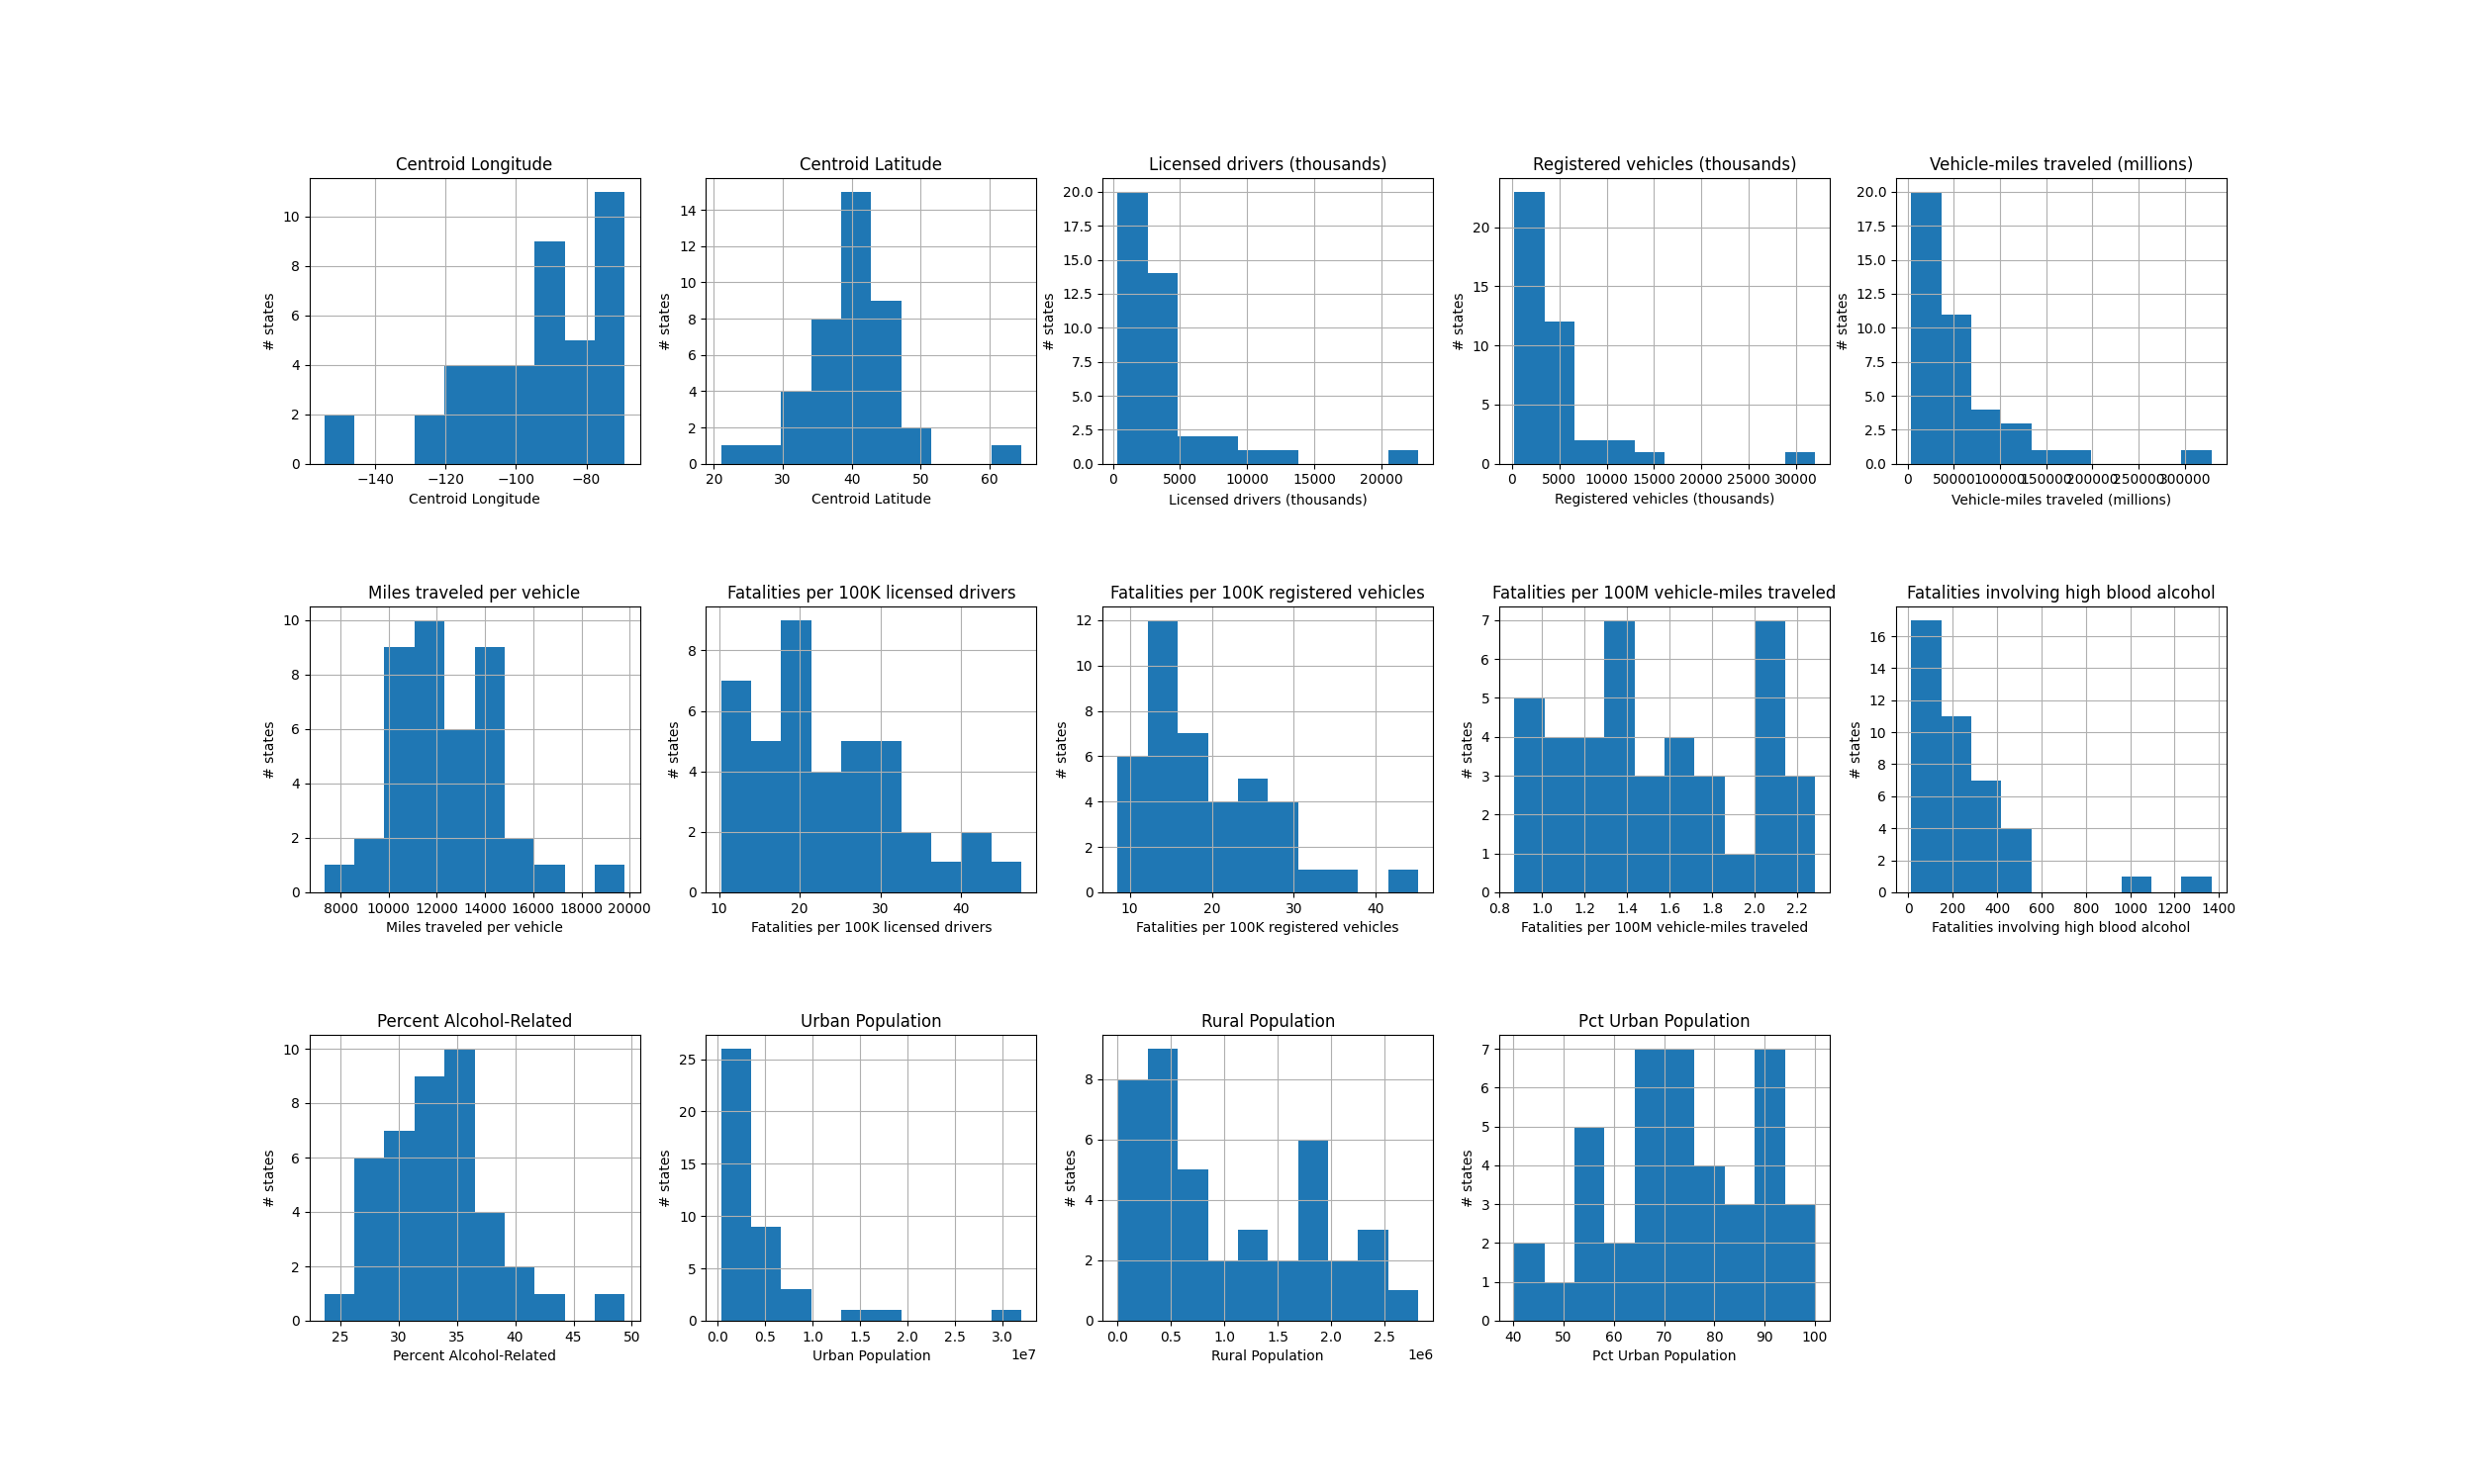

In [ ]:
# Dati originali

plt.figure(figsize=(25, 15))

for i in range(3) :
  for j in range(5) :
    if i * 5 + j < len(features):
      plt.subplot(3, 5, 5 * i + j + 1)
      plottafeat(features[i * 5 + j])

plt.subplots_adjust(hspace=0.5)
plt.show()

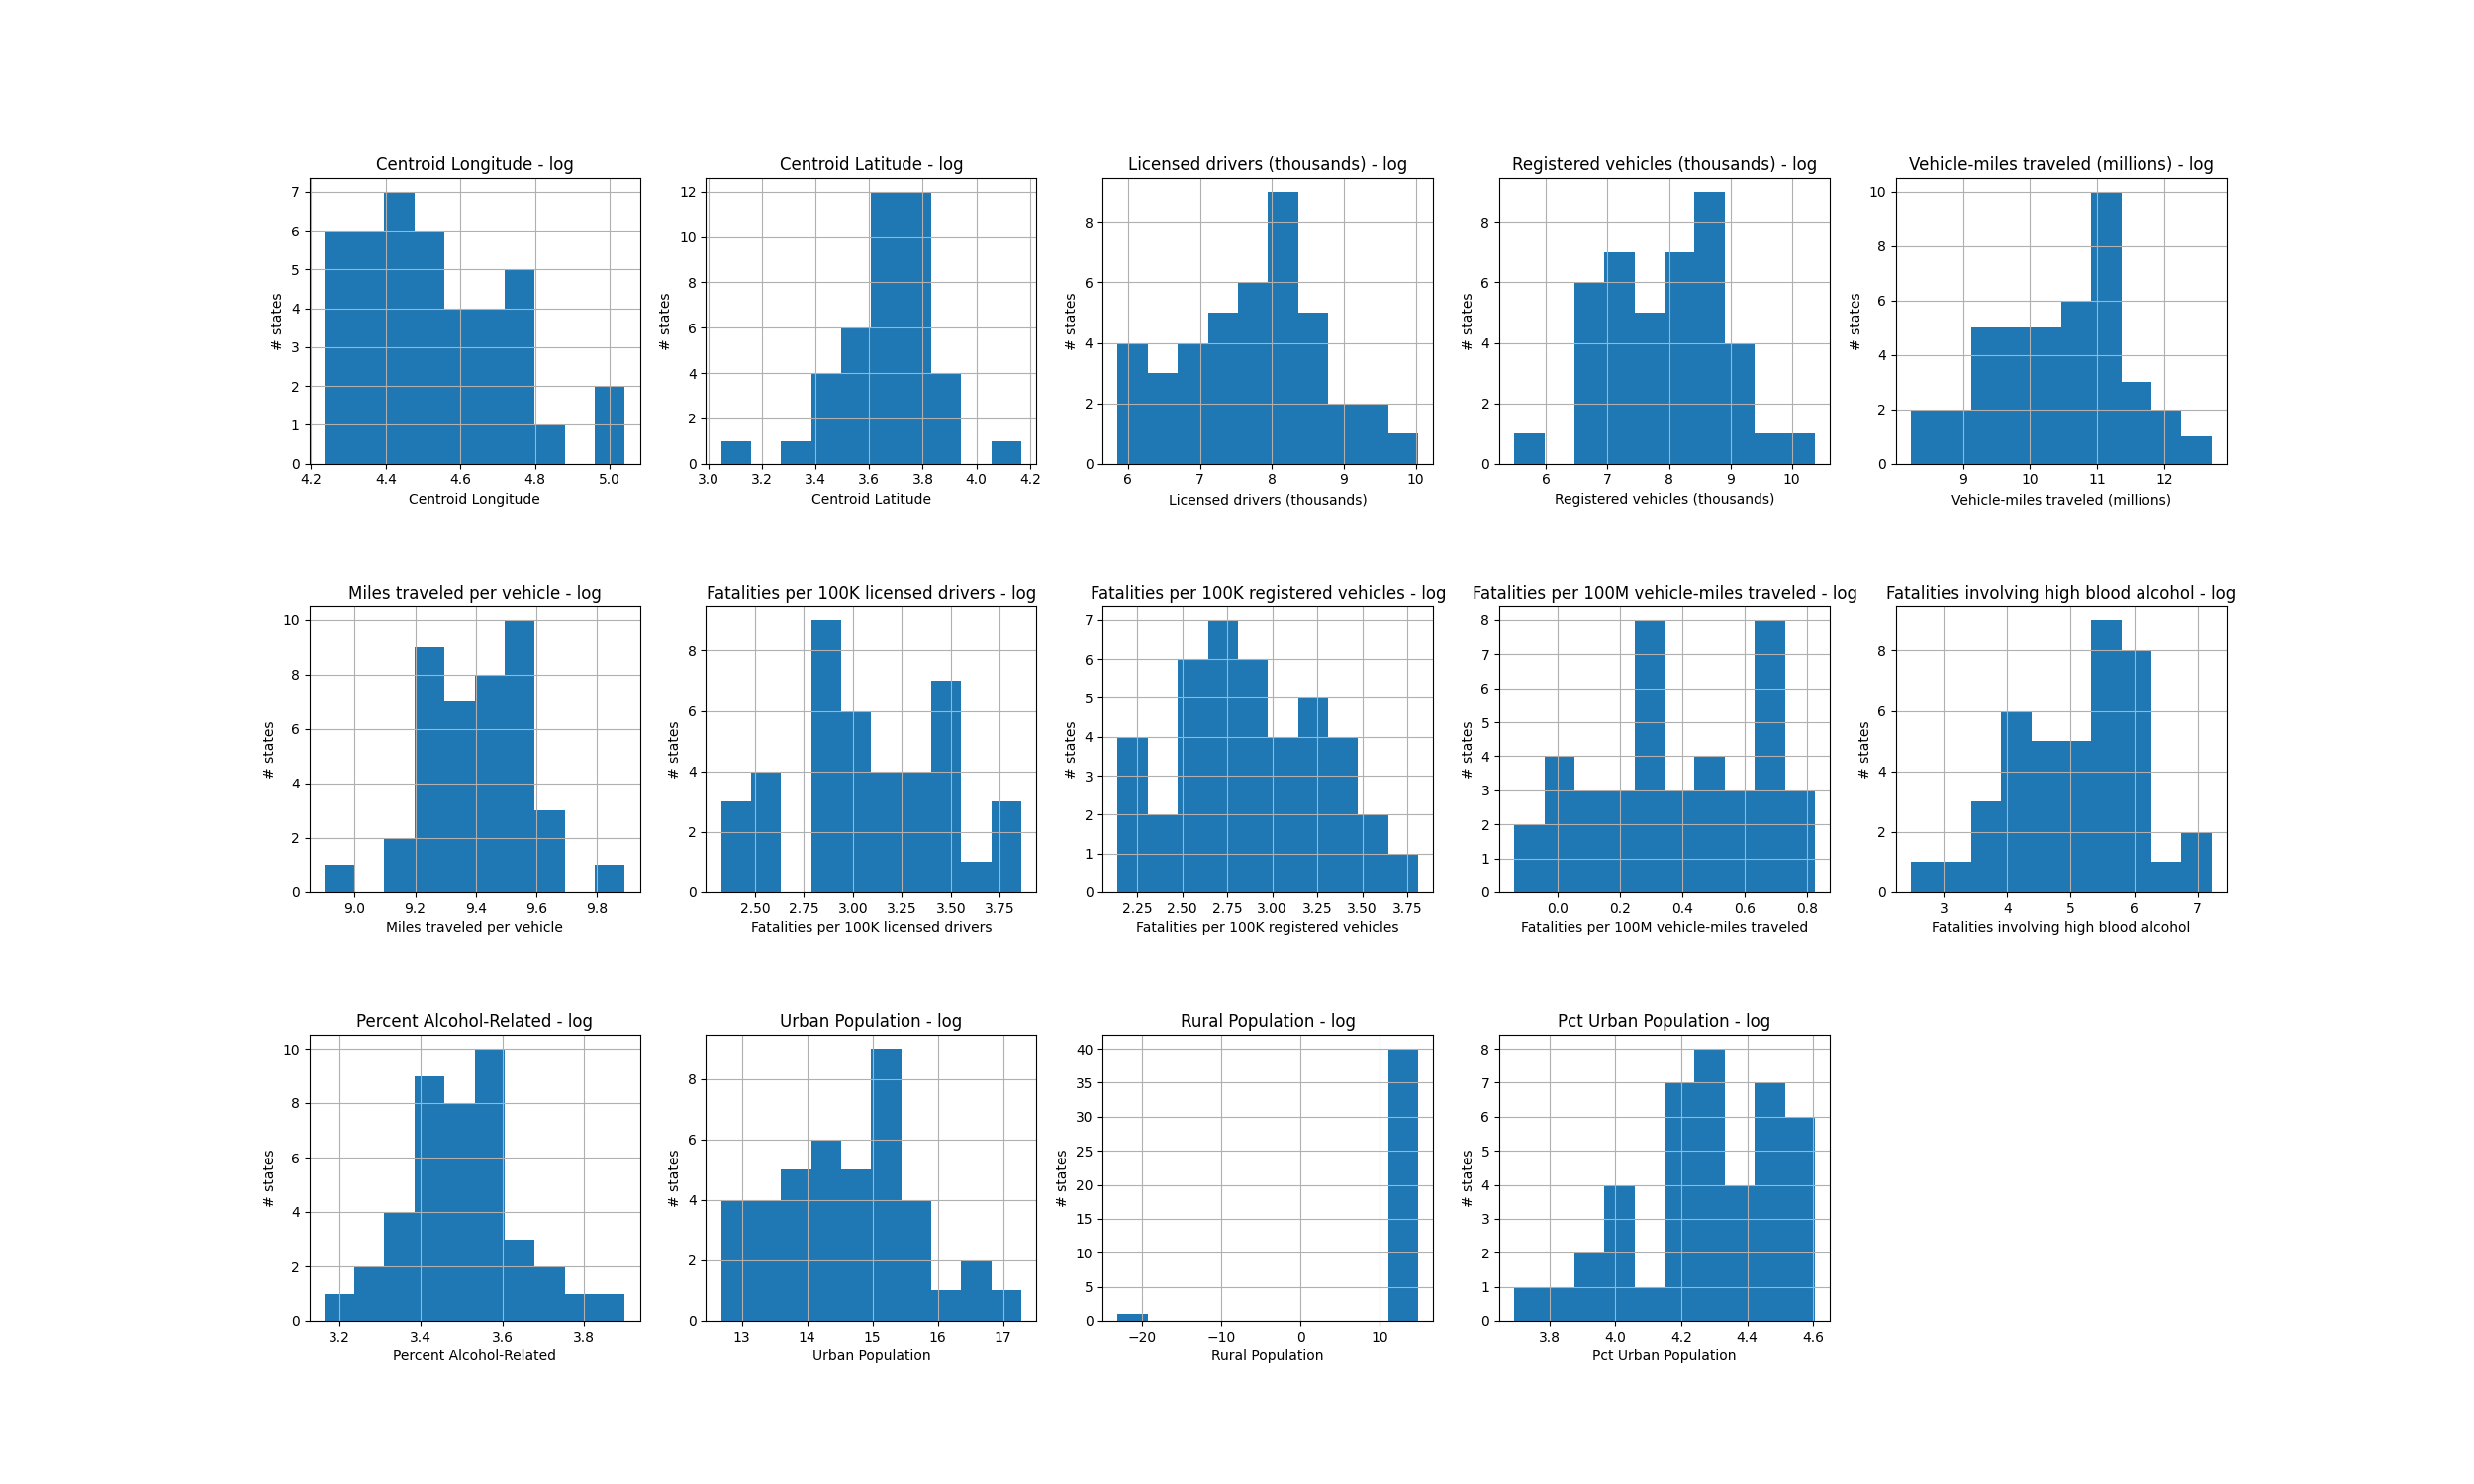

In [ ]:
# Dati sotto log

plt.figure(figsize=(25, 15))

for i in range(3) :
  for j in range(5) :
    if i * 5 + j < len(features):
      plt.subplot(3, 5, 5 * i + j + 1)
      plottafeat(features[i * 5 + j], log=True)

plt.subplots_adjust(hspace=0.5)
plt.show()

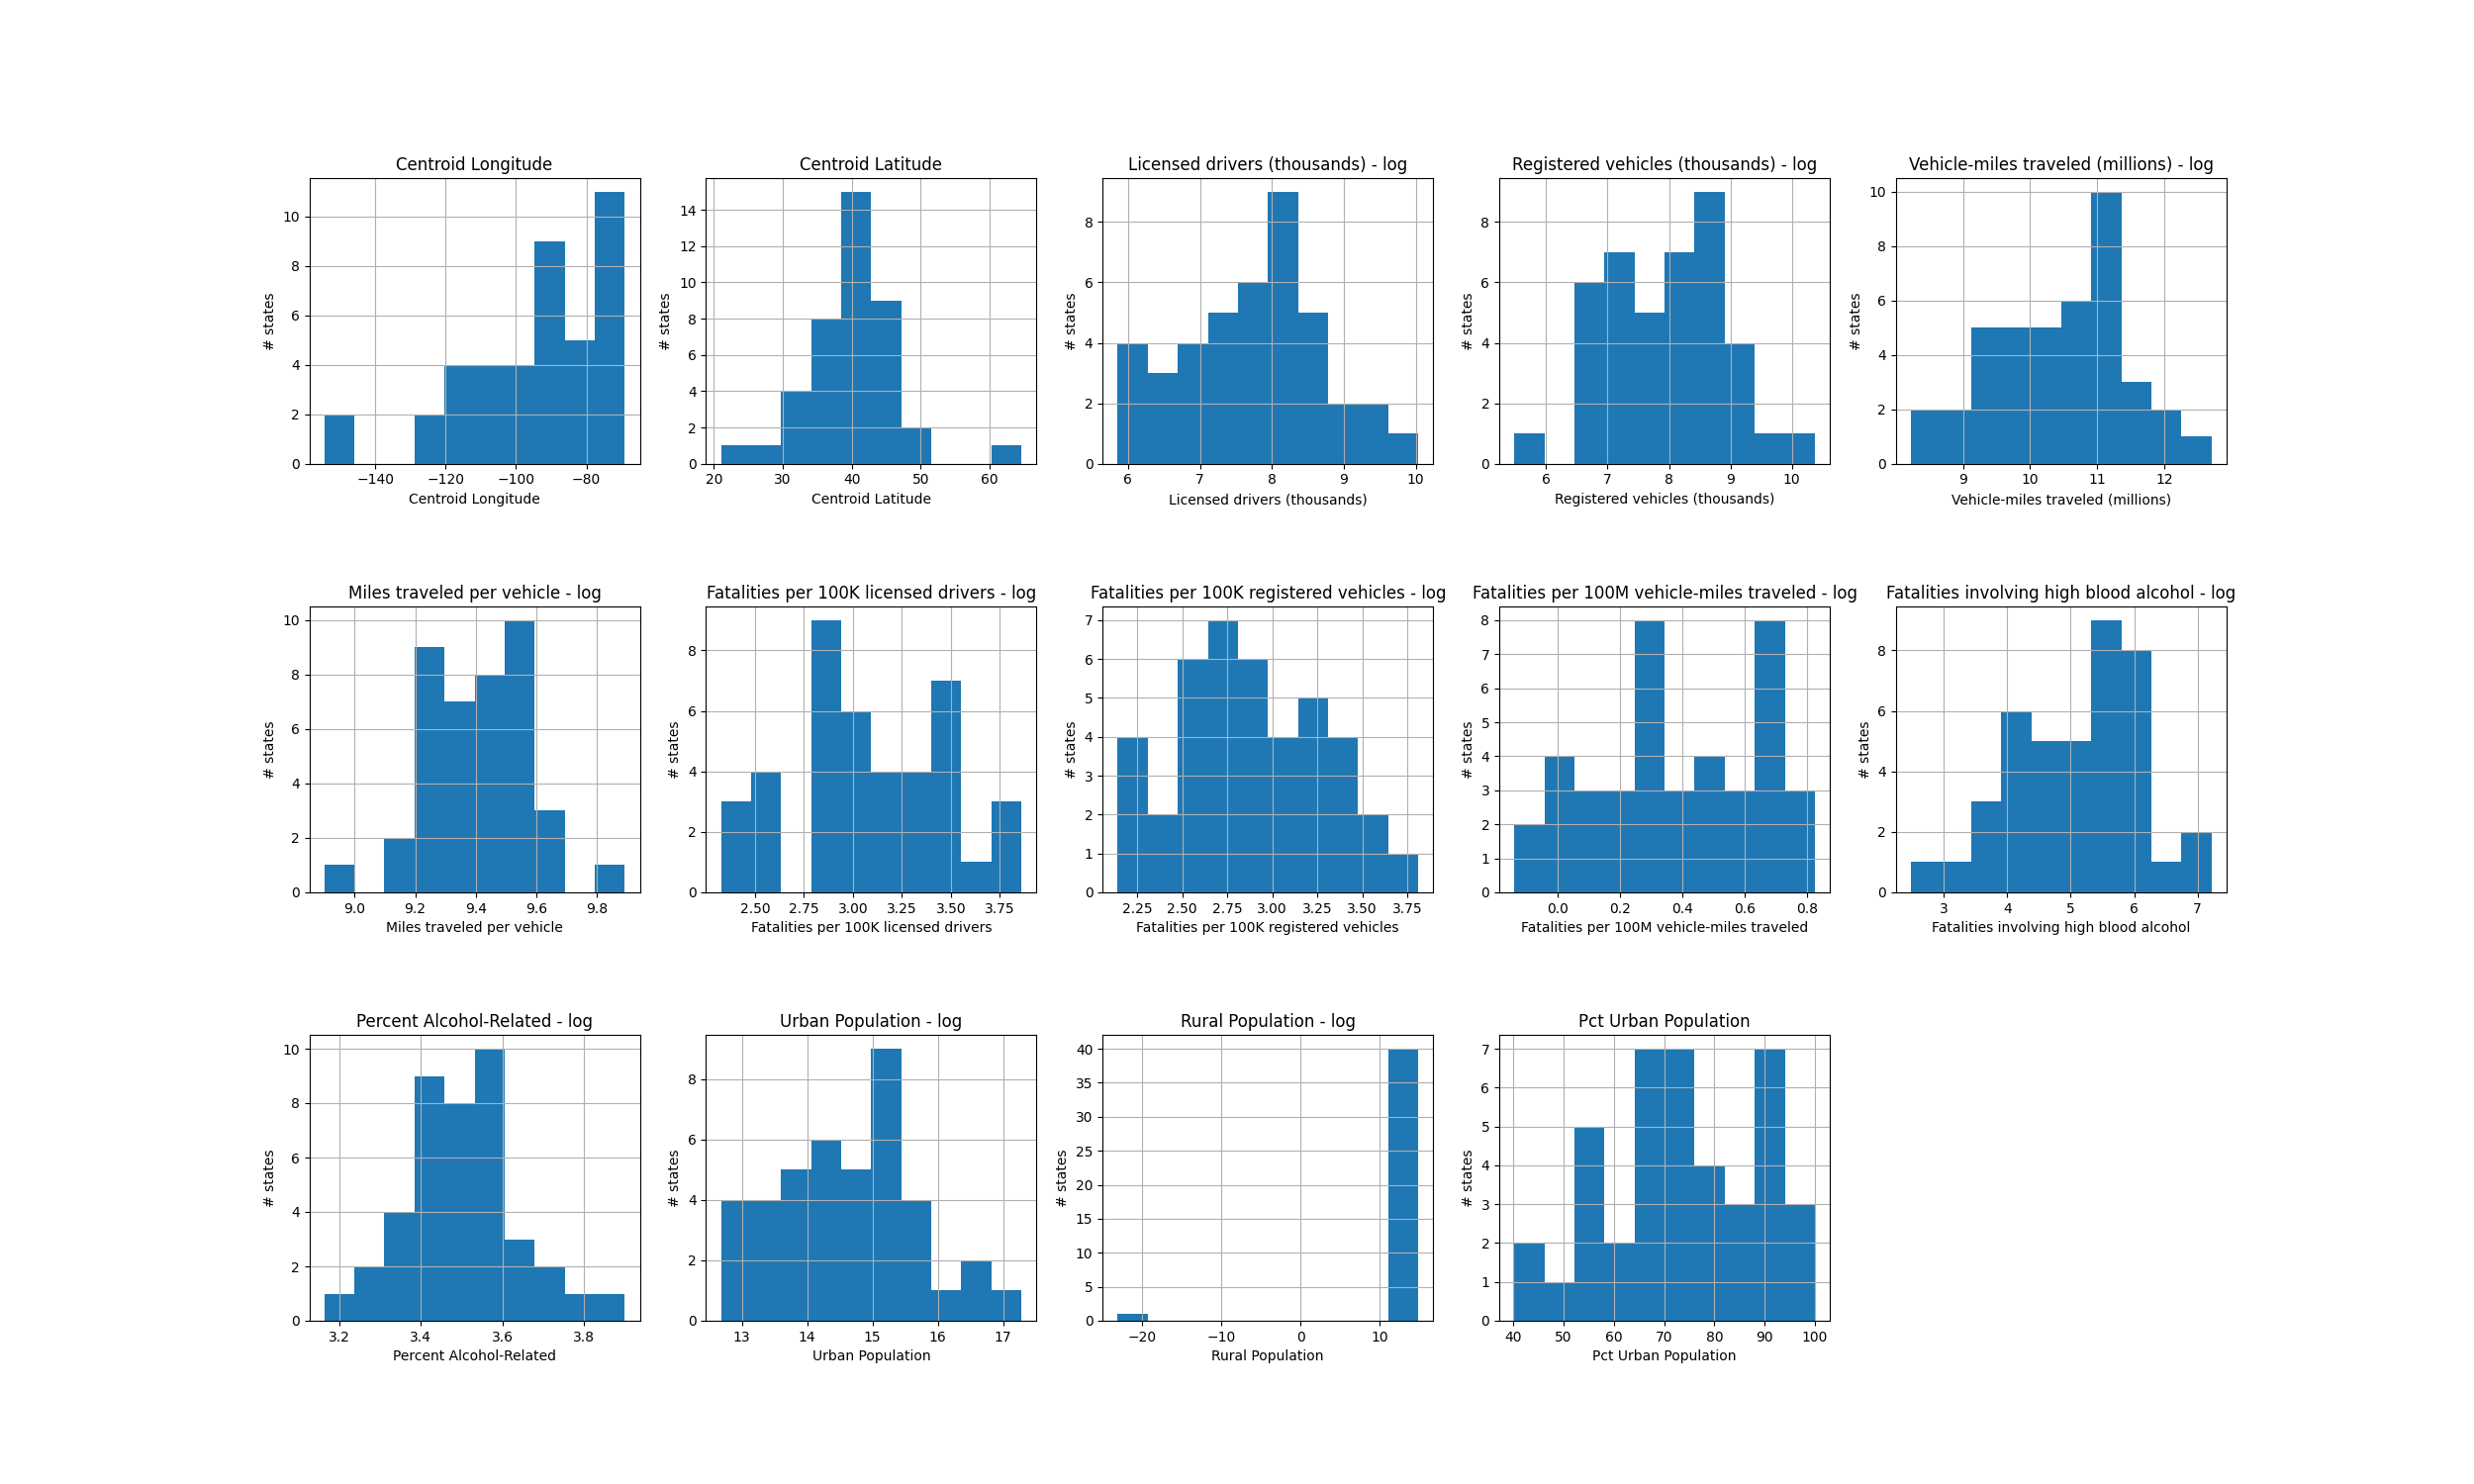

In [ ]:
# Dati con alcune feat sotto log

log_feat = [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0]
# log_feat = [1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0]
log_feat = np.array(log_feat, dtype=bool)

plt.figure(figsize=(25, 15))

for i in range(3) :
  for j in range(5) :
    if i * 5 + j < len(features):
      plt.subplot(3, 5, 5 * i + j + 1)
      plottafeat(features[i * 5 + j], log = log_feat[i * 3 + j])

plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
all_log_data_int = np.log(np.abs(data_int+1e-20))

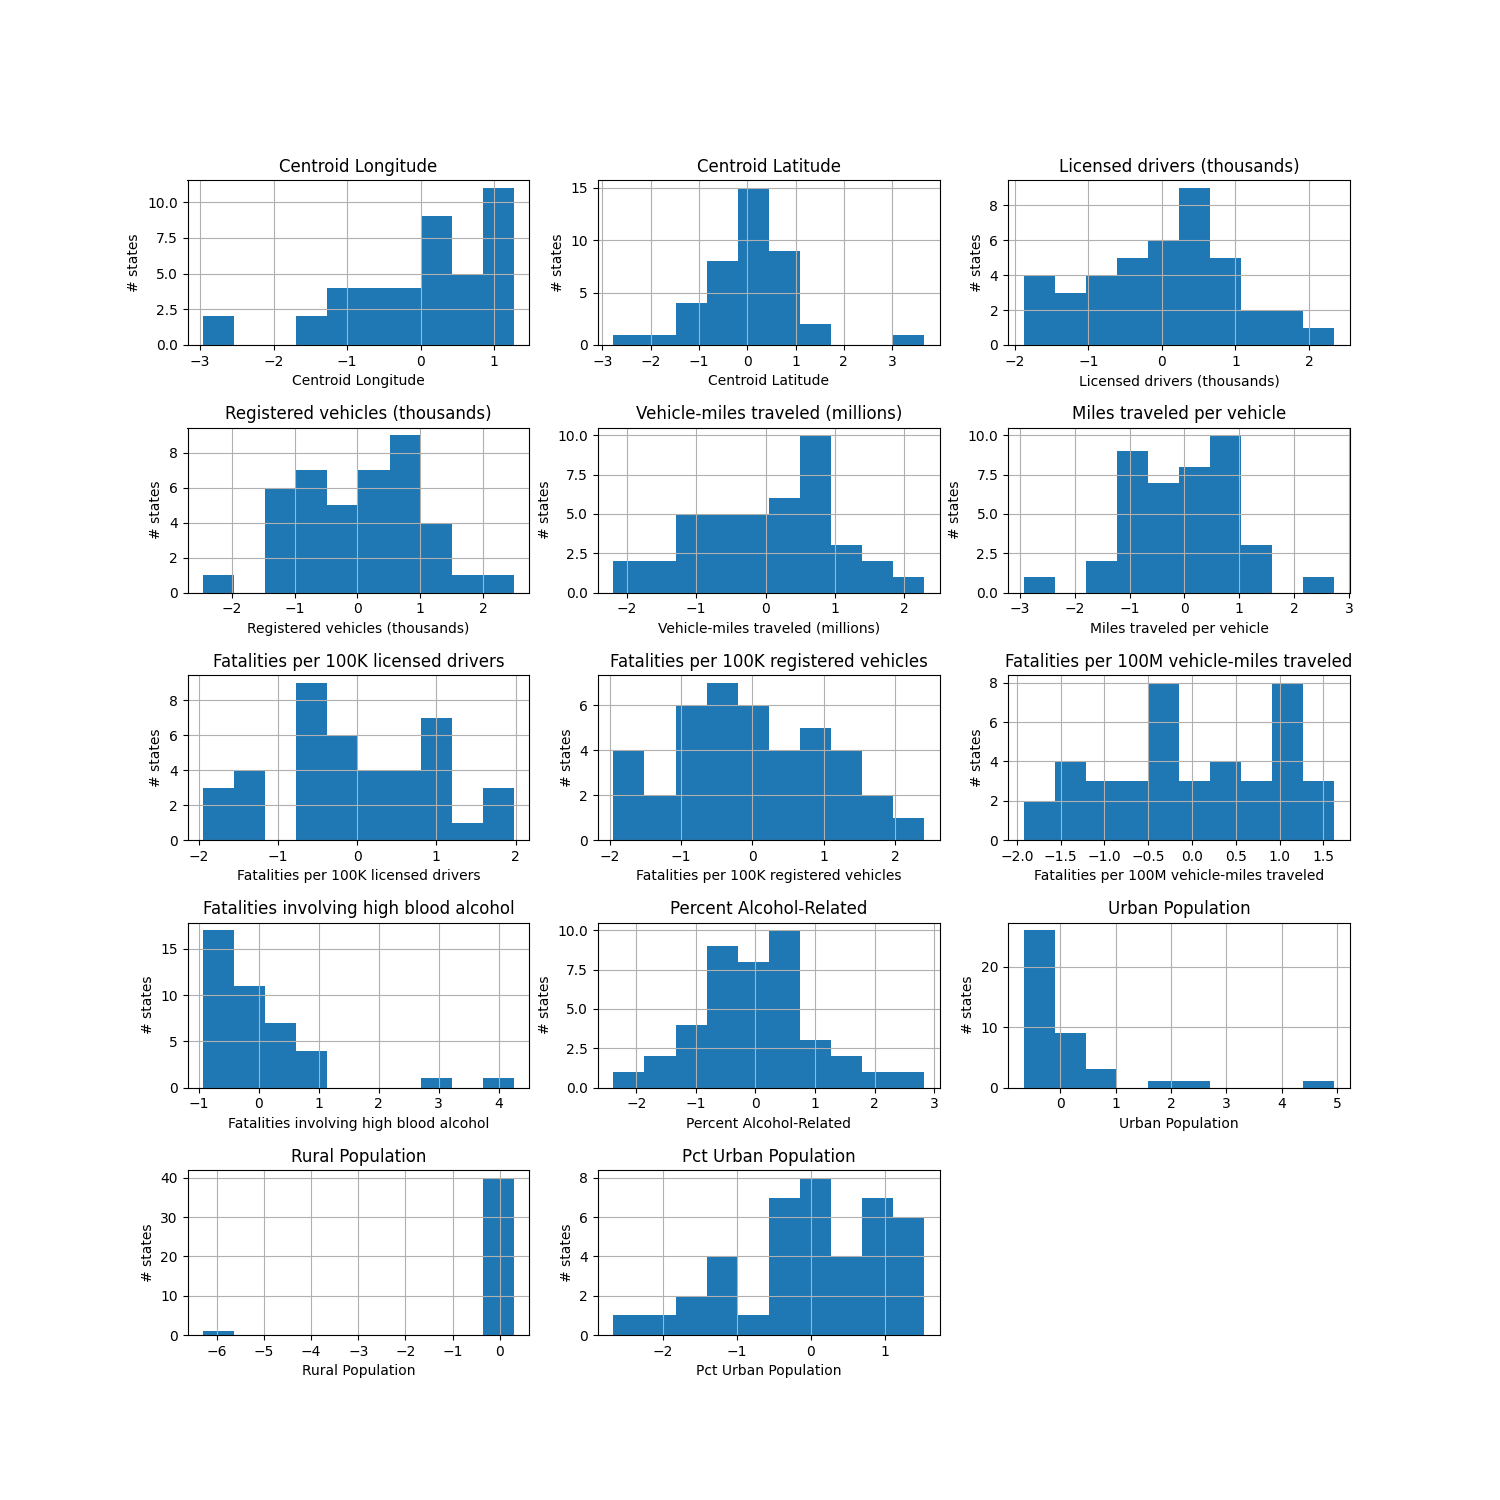

In [ ]:
log_data_int = data_int.copy()
log_data_ext = data_ext.copy()

for i, valore in enumerate(log_feat):
    if valore == 1:
        log_data_int[:, i] = np.log(np.abs(data_int[:, i] + 1e-20))
        log_data_ext[:, i] = np.log(np.abs(data_ext[:, i] + 1e-20))

scaler = StandardScaler()
scaled_ldata_int = scaler.fit_transform(log_data_int)

def plottafeat2(title):
  plt.hist(scaled_ldata_int[:,features.index(title)])
  plt.title(title)
  plt.xlabel(title)
  plt.ylabel('# states')
  plt.grid()

plt.figure(figsize=(15, 15))

for i in range(5) :
  for j in range(3) :
    if i * 3 + j < len(features):
      plt.subplot(5, 3, 3 * i + j + 1)
      plottafeat2(features[i * 3 + j])

plt.subplots_adjust(hspace=0.5)
plt.show()

## Matrice dei coefficienti di correlazione dei dati con calcolo degli autovalori e autovettori

In [ ]:
# scaler = StandardScaler()
# scaled_data_int = scaler.fit_transform(data_int)

cov_mat = np.corrcoef(data_int, rowvar=False)        # Calcola matrice correlazione di Pearson tra le features  (check rowvar)
eig_val, eig_vec = np.linalg.eig(cov_mat)            # Calcola autovettori e autovalori matrice covarianza
sorted_idcs = np.argsort(eig_val)[::-1]

eig_val = eig_val[sorted_idcs]
eig_vec = eig_vec[:,sorted_idcs]
sorted_features = list(np.array(features)[sorted_idcs])
sorted_data_int = data_int[:,sorted_idcs]           # Dataset ordinato in ordine decrescente rispetto agli autovalori
sorted_data_ext = data_ext[:,sorted_idcs]
pd.options.display.float_format = '{:,.3e}'.format
jupyprint('## Correlation Matrix:')
jupyprint(pd.DataFrame(cov_mat))
jupyprint('## Eigenvectors:')
jupyprint(pd.DataFrame(eig_vec, columns = ['v'+str(i) for i in range(len(eig_vec))]))
jupyprint('## Eigenvalues:')
jupyprint(pd.DataFrame(eig_val.reshape(1, -1), index = ['λ'], columns = ['λ'+str(i) for i in range(len(eig_val))]))


## Correlation Matrix:

0          1          2          3          4          5   \
0   1.000e+00 -1.109e-01  7.191e-02  2.678e-02  6.870e-02  2.809e-01   
1  -1.109e-01  1.000e+00 -1.833e-01 -1.695e-01 -2.274e-01 -4.844e-01   
2   7.191e-02 -1.833e-01  1.000e+00  9.901e-01  9.898e-01 -1.341e-01   
3   2.678e-02 -1.695e-01  9.901e-01  1.000e+00  9.896e-01 -1.542e-01   
4   6.870e-02 -2.274e-01  9.898e-01  9.896e-01  1.000e+00 -6.589e-02   
5   2.809e-01 -4.844e-01 -1.341e-01 -1.542e-01 -6.589e-02  1.000e+00   
6  -1.371e-01 -3.105e-01 -2.225e-01 -2.042e-01 -1.425e-01  6.713e-01   
7  -5.110e-02 -4.209e-01 -2.088e-01 -2.156e-01 -1.438e-01  8.295e-01   
8  -3.089e-01 -2.470e-01 -2.362e-01 -2.309e-01 -1.831e-01  4.993e-01   
9   5.299e-02 -3.426e-01  9.389e-01  9.347e-01  9.617e-01  5.304e-02   
10  2.643e-02  2.951e-03 -2.106e-02 -2.783e-02 -5.947e-02 -2.281e-01   
11  3.560e-02 -1.439e-01  9.867e-01  9.793e-01  9.654e-01 -1.681e-01   
12  2.911e-01 -1.881e-01  6.061e-01  5.747e-01  6.390e-01  1.869e-01   
13 -8.543e-02 -1.698e-01  3.688e-01  3.434e-01  3.152e-01 -2.869e-01   

           6          7          8          9          10         11  \
0  -1.371e-01 -5.110e-02 -3.089e-01  5.299e-02  2.643e-02  3.560e-02   
1  -3.105e-01 -4.209e-01 -2.470e-01 -3.426e-01  2.951e-03 -1.439e-01   
2  -2.225e-01 -2.088e-01 -2.362e-01  9.389e-01 -2.106e-02  9.867e-01   
3  -2.042e-01 -2.156e-01 -2.309e-01  9.347e-01 -2.783e-02  9.793e-01   
4  -1.425e-01 -1.438e-01 -1.831e-01  9.617e-01 -5.947e-02  9.654e-01   
5   6.713e-01  8.295e-01  4.993e-01  5.304e-02 -2.281e-01 -1.681e-01   
6   1.000e+00  9.061e-01  8.776e-01  3.500e-02 -1.036e-01 -2.627e-01   
7   9.061e-01  1.000e+00  8.860e-01  4.874e-02 -1.165e-01 -2.476e-01   
8   8.776e-01  8.860e-01  1.000e+00  2.228e-02 -7.785e-02 -2.717e-01   
9   3.500e-02  4.874e-02  2.228e-02  1.000e+00  2.728e-03  8.913e-01   
10 -1.036e-01 -1.165e-01 -7.785e-02  2.728e-03  1.000e+00 -1.116e-02   
11 -2.627e-01 -2.476e-01 -2.717e-01  8.913e-01 -1.116e-02  1.000e+00   
12  9.969e-02  1.068e-01  2.238e-02  6.601e-01 -1.105e-01  5.126e-01   
13 -5.940e-01 -4.755e-01 -5.186e-01  2.247e-01  1.490e-01  4.197e-01   

           12         13  
0   2.911e-01 -8.543e-02  
1  -1.881e-01 -1.698e-01  
2   6.061e-01  3.688e-01  
3   5.747e-01  3.434e-01  
4   6.390e-01  3.152e-01  
5   1.869e-01 -2.869e-01  
6   9.969e-02 -5.940e-01  
7   1.068e-01 -4.755e-01  
8   2.238e-02 -5.186e-01  
9   6.601e-01  2.247e-01  
10 -1.105e-01  1.490e-01  
11  5.126e-01  4.197e-01  
12  1.000e+00 -1.803e-01  
13 -1.803e-01  1.000e+00

## Eigenvectors:

v0         v1         v2         v3         v4         v5  \
0   4.671e-02 -1.900e-02  8.015e-01 -3.510e-02  1.719e-01 -2.524e-01   
1  -6.248e-02  2.777e-01 -1.076e-01  6.157e-01  1.523e-01 -6.188e-01   
2   4.108e-01 -9.082e-02 -5.368e-02  3.742e-02  8.597e-03 -1.016e-01   
3   4.071e-01 -8.871e-02 -9.198e-02  5.684e-02  3.120e-03 -9.900e-02   
4   4.035e-01 -1.313e-01 -4.733e-02  4.922e-02 -1.007e-02 -6.612e-02   
5  -1.069e-01 -3.994e-01  3.003e-01 -2.053e-01 -1.685e-01 -3.536e-01   
6  -1.676e-01 -4.380e-01 -1.483e-01  5.097e-02  9.391e-02 -1.052e-01   
7  -1.623e-01 -4.594e-01 -5.820e-02 -9.637e-02  1.553e-02 -2.101e-01   
8  -1.739e-01 -3.974e-01 -3.260e-01  5.274e-02  9.157e-02 -3.469e-02   
9   3.699e-01 -2.199e-01 -8.194e-02 -6.385e-03  7.824e-02 -1.458e-02   
10  6.650e-03  1.051e-01 -1.077e-01 -3.712e-01  8.926e-01 -5.811e-02   
11  4.063e-01 -5.800e-02 -9.039e-02  1.146e-02 -1.909e-02 -2.108e-01   
12  2.414e-01 -2.337e-01  2.691e-01  3.129e-01  1.740e-01  5.023e-01   
13  2.006e-01  2.269e-01 -1.080e-01 -5.657e-01 -2.602e-01 -2.170e-01   

           v6         v7         v8         v9        v10        v11  \
0   3.294e-01  3.768e-01 -8.093e-02  3.617e-02 -4.434e-02 -1.017e-02   
1  -3.149e-01  9.717e-02 -5.344e-02 -1.004e-01 -4.174e-03  2.291e-02   
2   5.590e-02 -2.629e-03  7.205e-02  1.628e-01  2.073e-01  2.718e-01   
3   1.356e-01 -1.302e-01 -1.408e-02  7.441e-03 -7.130e-01 -2.545e-01   
4   6.255e-02 -7.855e-02 -6.672e-02 -1.669e-01 -1.624e-01 -1.877e-01   
5  -3.778e-01 -4.347e-01  1.658e-01 -1.169e-01  1.602e-01 -3.575e-01   
6   1.319e-01 -8.791e-02 -8.310e-01  1.043e-01  6.983e-02  4.044e-02   
7  -1.192e-01  8.873e-02  2.842e-01  1.063e-01 -3.570e-01  6.523e-01   
8   9.444e-02  6.036e-01  2.651e-01  5.611e-02  7.743e-02 -4.767e-01   
9   9.099e-02  1.052e-01  2.675e-02 -7.085e-01  3.320e-01  1.985e-01   
10 -1.135e-01 -1.422e-01  4.312e-02  1.723e-02 -5.720e-03 -5.413e-02   
11  9.840e-02 -8.248e-02  1.143e-01  6.116e-01  3.760e-01 -2.760e-02   
12 -6.105e-01  1.674e-01 -9.706e-02  1.369e-01 -2.470e-02 -9.108e-03   
13 -4.245e-01  4.364e-01 -2.943e-01  9.179e-03 -6.370e-02  7.147e-03   

          v12        v13  
0   8.855e-04  1.182e-02  
1  -6.610e-03  1.041e-02  
2   1.717e-01 -7.919e-01  
3  -4.281e-01 -1.136e-01  
4   7.967e-01  2.684e-01  
5  -4.714e-02 -1.214e-01  
6  -3.949e-02 -3.072e-02  
7   7.587e-02  1.809e-01  
8   2.551e-02 -1.121e-01  
9  -3.156e-01  1.745e-01  
10  3.029e-02 -1.529e-02  
11 -1.957e-01  4.408e-01  
12 -5.593e-02  4.001e-02  
13 -1.779e-02  9.290e-03

## Eigenvalues:

λ0        λ1        λ2        λ3        λ4        λ5        λ6  \
λ 5.654e+00 3.788e+00 1.359e+00 1.201e+00 9.636e-01 4.232e-01 2.819e-01   

         λ7        λ8        λ9       λ10       λ11       λ12       λ13  
λ 1.756e-01 8.900e-02 4.432e-02 8.643e-03 6.769e-03 2.715e-03 1.370e-03

## PCA (Analisi delle componenti principali)

Eigenvalue Percentage Cumulative
λ0   5.654e+00    40.389%    40.389%
λ1   3.788e+00    27.056%    67.445%
λ2   1.359e+00     9.708%    77.153%
λ3   1.201e+00     8.581%    85.735%
λ4   9.636e-01     6.883%    92.618%
λ5   4.232e-01     3.023%     95.64%
λ6   2.819e-01     2.014%    97.654%
λ7   1.756e-01     1.254%    98.908%
λ8   8.900e-02     0.636%    99.544%
λ9   4.432e-02     0.317%    99.861%
λ10  8.643e-03     0.062%    99.922%
λ11  6.769e-03     0.048%    99.971%
λ12  2.715e-03     0.019%     99.99%
λ13  1.370e-03      0.01%     100.0%
-            -          -          -
TOT       14.0     100.0%          -

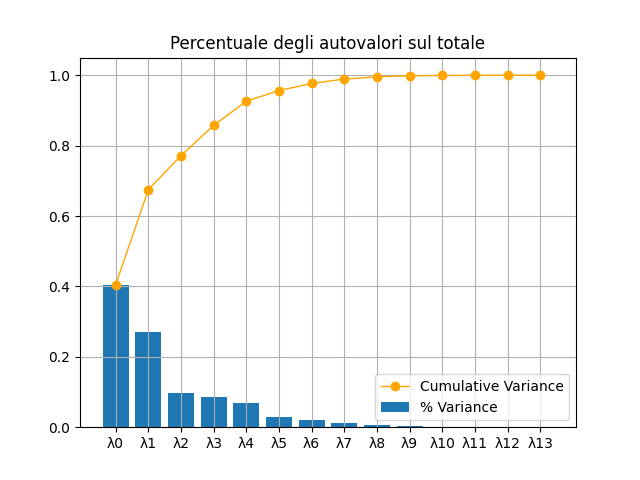

In [ ]:
# Analisi autovalori

sum_ev = np.round(np.sum(eig_val), 1)

percentage_ev = np.abs(eig_val/sum_ev)
cumulative = np.cumsum(percentage_ev)
Tab = np.column_stack((['{:0.3e}'.format(num) for num in eig_val], ['{}%'.format(np.round(num*100,3)) for num in percentage_ev], ['{}%'.format(np.round(num*100,3)) for num in cumulative]))
end_line = np.vstack([['-','-','-'], [sum_ev, '{}%'.format(np.sum(percentage_ev)*100 // 1), '-']])
df = pd.DataFrame(np.vstack([Tab, end_line]), index = [f'λ{str(i)}' for i in range(len(eig_val))]+['-','TOT'], columns = ['Eigenvalue', 'Percentage', 'Cumulative'])

jupyprint(df)

plt.figure()
plt.title('Percentuale degli autovalori sul totale') # Più che la varianza non sto plottando la percentuale sul totale?
plt.xticks(range(1,len(eig_val)+1), ['λ'+str(i) for i in range(len(eig_val))])
plt.bar(range(1,len(eig_val)+1),percentage_ev, label = '% Variance')
plt.plot(range(1,len(eig_val)+1),cumulative, linewidth=1, marker='o', color = 'orange', label = 'Cumulative Variance')
plt.legend()
plt.grid()
plt.show()

In [2]:
# Visualizza autovettore
vec_index = 3

plt.figure()
plt.subplots_adjust(bottom=0.5)
plt.title(f'Coefficienti autovettore {vec_index} in valore assoluto')
plt.xticks(range(0,len(eig_vec)), features, rotation=45, ha='right')
plt.plot(np.abs(eig_vec[vec_index]))
plt.grid()
plt.show()

NameError: name 'plt' is not defined

### Scelta delle componenti principali

In [ ]:
# Percentuale di varianza spiegata
t = 0.96

pc_eval = eig_val[cumulative < t] # prendo gli autovalori che spieghino un tot percentuale (t) della varianza
pc_evec = eig_vec[:,cumulative < t] # prendo i corrispettivi autovettori

pc_data_int = sorted_data_int @ pc_evec # Prodotto scalare tra matrice di dati (righe features, colonne stati) e matrice di autovettori principali disposti in colonna
pc_data_ext = sorted_data_ext @ pc_evec

jupyprint(pd.DataFrame(pc_eval.reshape(1,-1), index = ['pc λ'], columns = ['λ'+str(i) for i in range(len(pc_eval))]))
jupyprint(pd.DataFrame(pc_data_int, index = state_names_int, columns = ['Y'+str(i) for i in range(len(pc_eval))]))



λ0        λ1        λ2        λ3        λ4        λ5
pc λ 5.654e+00 3.788e+00 1.359e+00 1.201e+00 9.636e-01 4.232e-01

Y0         Y1         Y2         Y3         Y4  \
New Jersey           3.354e+06 -3.679e+05 -7.699e+05 -1.762e+05 -2.778e+05   
Maryland             2.024e+06 -1.103e+05 -4.910e+05 -3.648e+05 -2.818e+05   
Arkansas             8.374e+05  1.961e+05 -2.610e+05 -7.048e+05 -3.606e+05   
Massachusetts        2.493e+06 -2.249e+05 -5.840e+05 -2.410e+05 -2.549e+05   
Indiana              2.137e+06  1.379e+05 -5.813e+05 -9.546e+05 -5.474e+05   
Alaska               2.122e+05  2.117e+04 -5.870e+04 -1.180e+05 -6.506e+04   
Rhode Island         4.094e+05 -3.907e+04 -9.395e+04 -4.439e+04 -4.466e+04   
Idaho                4.421e+05  4.242e+04 -1.224e+05 -2.374e+05 -1.314e+05   
Missouri             1.951e+06  1.481e+05 -5.357e+05 -9.242e+05 -5.231e+05   
Montana              2.854e+05  5.991e+04 -8.642e+04 -2.305e+05 -1.191e+05   
Oklahoma             1.176e+06  1.282e+05 -3.314e+05 -6.511e+05 -3.571e+05   
Washington           2.202e+06 -5.163e+04 -5.520e+05 -5.440e+05 -3.706e+05   
Connecticut          1.312e+06 -8.703e+04 -3.141e+05 -2.029e+05 -1.679e+05   
Georgia              2.899e+06  1.642e+05 -7.830e+05 -1.242e+06 -7.190e+05   
Florida              6.233e+06 -4.742e+05 -1.482e+06 -7.942e+05 -7.208e+05   
Alabama              1.425e+06  2.928e+05 -4.365e+05 -1.092e+06 -5.654e+05   
West Virginia        5.420e+05  1.642e+05 -1.775e+05 -5.438e+05 -2.722e+05   
Oregon               1.256e+06 -7.240e+02 -3.208e+05 -3.817e+05 -2.433e+05   
Arizona              1.985e+06 -1.387e+05 -4.735e+05 -2.913e+05 -2.472e+05   
Wisconsin            1.857e+06  1.590e+05 -5.146e+05 -9.179e+05 -5.145e+05   
Tennessee            1.917e+06  2.440e+05 -5.507e+05 -1.129e+06 -6.107e+05   
Kansas               9.467e+05  5.382e+04 -2.547e+05 -4.134e+05 -2.389e+05   
Utah                 8.637e+05 -6.308e+04 -2.045e+05 -1.267e+05 -1.080e+05   
New Hampshire        4.035e+05  6.582e+04 -1.182e+05 -2.784e+05 -1.471e+05   
Kentucky             1.294e+06  2.630e+05 -3.954e+05 -9.869e+05 -5.115e+05   
Hawaii               4.748e+05 -4.659e+04 -1.090e+05 -4.665e+04 -4.956e+04   
Wyoming              1.680e+05  1.341e+04 -4.412e+04 -9.573e+04 -5.320e+04   
Delaware             2.891e+05 -7.322e+03 -7.034e+04 -8.344e+04 -5.490e+04   
Pennsylvania         4.460e+06  7.070e+04 -1.163e+06 -1.483e+06 -9.171e+05   
New Mexico           6.550e+05  1.434e+04 -1.693e+05 -2.431e+05 -1.470e+05   
District of Columbia 2.325e+05 -3.997e+04 -4.730e+04  3.615e+03 -1.354e+04   
Michigan             3.567e+06  1.212e+05 -9.452e+05 -1.336e+06 -8.000e+05   
New York             7.286e+06 -4.492e+05 -1.762e+06 -1.148e+06 -9.383e+05   
Maine                3.667e+05  1.356e+05 -1.255e+05 -4.273e+05 -2.105e+05   
Mississippi          8.718e+05  2.362e+05 -2.790e+05 -8.097e+05 -4.091e+05   
Nevada               7.848e+05 -7.660e+04 -1.804e+05 -7.621e+04 -8.137e+04   
California           1.353e+07 -1.483e+06 -3.112e+06 -6.783e+05 -1.104e+06   
Minnesota            1.730e+06  1.091e+05 -4.696e+05 -7.682e+05 -4.412e+05   
Nebraska             5.965e+05  4.118e+04 -1.617e+05 -2.808e+05 -1.597e+05   
Louisiana            1.584e+06  7.763e+04 -4.247e+05 -6.539e+05 -3.823e+05   
North Dakota         2.050e+05  3.827e+04 -6.041e+04 -1.581e+05 -8.250e+04   

                             Y5  
New Jersey           -1.787e+06  
Maryland             -1.130e+06  
Arkansas             -5.797e+05  
Massachusetts        -1.350e+06  
Indiana              -1.303e+06  
Alaska               -1.365e+05  
Rhode Island         -2.259e+05  
Idaho                -2.804e+05  
Missouri             -1.201e+06  
Montana              -1.974e+05  
Oklahoma             -7.436e+05  
Washington           -1.257e+06  
Connecticut          -7.269e+05  
Georgia              -1.754e+06  
Florida              -3.401e+06  
Alabama              -9.592e+05  
West Virginia        -3.940e+05  
Oregon               -7.329e+05  
Arizona              -1.095e+06  
Wisconsin            -1.151e+06  
Tennessee            -1.223e+06  
Kan

## Folding

In [ ]:
K = 3
n_est = 5
ML = ABC123(data_int, labels_int)
ML_log = ABC123(log_data_int, labels_int)
pc_ML = ABC123(pc_data_int, labels_int)

fd = ML.data_folding(K, show_kfold = True)
ML_models = {'SVM': SVC(kernel='linear', C=2, probability=True), 'Random Forest': RFC(n_estimators = n_est, criterion = 'gini')}
pc_ML_models = {'SVM': SVC(kernel='linear', C=2, probability=True), 'Random Forest': RFC(n_estimators = n_est, criterion = 'gini')}

### Indici delle fold associate a ciascun campione:

$\begin{bmatrix}{} 0 & 0 & 1 & 1 & 0 & 2 & 2 & 1 & 0 & 0 & 0 & 2 & 0 & 1 & 0 & 1 & 2 & 0 & 1 & 2 & 1 & 0 & 2 & 0 & 0 & 2 & 1 & 2 & 1 & 1 & 1 & 1 & 2 & 1 & 2 & 1 & 0 & 2 & 0 & 2 & 2 \end{bmatrix}$

## Test variando K

k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9


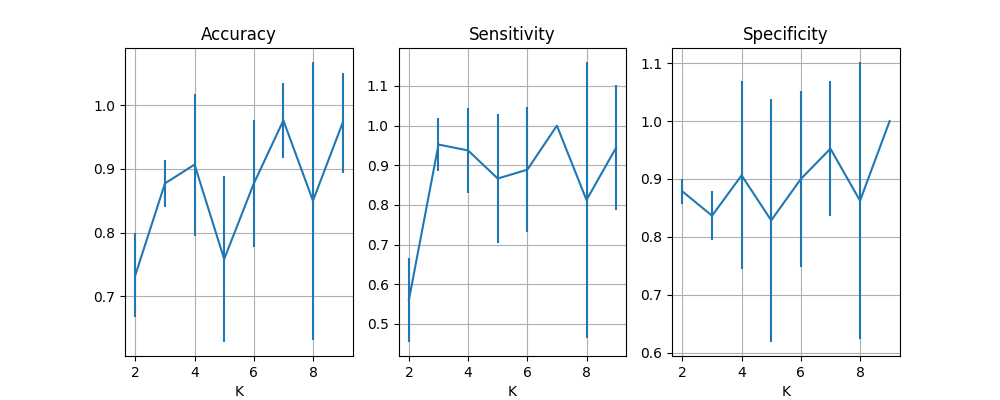

In [ ]:
k1 = 2
k2 = 10

ACC = np.zeros(k2-k1)
ACC_err = np.zeros(k2-k1)
SENS = np.zeros(k2-k1)
SENS_err = np.zeros(k2-k1)
SPEC = np.zeros(k2-k1)
SPEC_err = np.zeros(k2-k1)

for k in range(k1,k2):
  fd_2 = ML.data_folding(k)
  results_2, prob_pred_2, models_2 = ML.train_test(SVC(kernel='linear', C=2, probability=True), folding = fd_2)
  accuracy = results_2['Accuracy']
  sensitivity = results_2['Sensitivity']
  specificity = results_2['Specificity']
  FP = results_2['FP']
  FN = results_2['FN']

  avg_results_2 = ML.avg_std_kfolds(results_2, table = False)

  ACC[k-k1] = avg_results_2['Avg']['Accuracy']
  ACC_err[k-k1] = avg_results_2['Std']['Accuracy']

  SENS[k-k1] = avg_results_2['Avg']['Sensitivity']
  SENS_err[k-k1] = avg_results_2['Std']['Sensitivity']

  SPEC[k-k1] = avg_results_2['Avg']['Specificity']
  SPEC_err[k-k1] = avg_results_2['Std']['Specificity']

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.errorbar(range(k1,k2), ACC, ACC_err)
plt.title('Accuracy')
plt.xlabel('K')
plt.grid()

plt.subplot(1, 3, 2)
plt.errorbar(range(k1,k2), SENS, SENS_err)
plt.title('Sensitivity')
plt.xlabel('K')
plt.grid()

plt.subplot(1, 3, 3)
plt.errorbar(range(k1,k2), SPEC, SPEC_err)
plt.title('Specificity')
plt.xlabel('K')
plt.grid()

plt.show()

## Test variando numero estimatori (Random Forest)

N_Tress =  1
k = 3
N_Tress =  2
k = 3
N_Tress =  3
k = 3
N_Tress =  4
k = 3
N_Tress =  5
k = 3
N_Tress =  6
k = 3
N_Tress =  7
k = 3
N_Tress =  8
k = 3
N_Tress =  9
k = 3
N_Tress =  10
k = 3
N_Tress =  11
k = 3
N_Tress =  12
k = 3
N_Tress =  13
k = 3
N_Tress =  14
k = 3


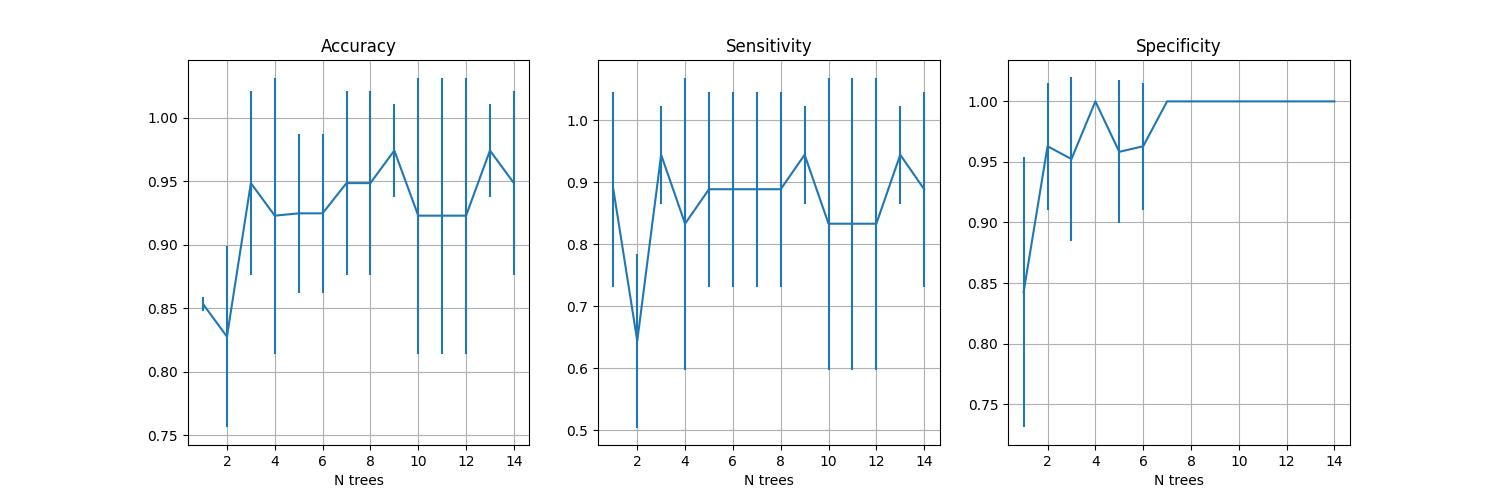

In [ ]:
TreeMin = 1
TreeMax = 15
nPts = 14
step = int((TreeMax-TreeMin)/ nPts)


# Metrics
ACC = np.zeros(nPts)
ACC_err = np.zeros(nPts)
SENS = np.zeros(nPts)
SENS_err = np.zeros(nPts)
SPEC = np.zeros(nPts)
SPEC_err = np.zeros(nPts)

fd_3 = ML.data_folding(K)

for n in range(nPts):

  # Metrics
  accuracy = np.zeros(K)
  sensitivity = np.zeros(K)
  specificity = np.zeros(K)

  _nTrees = n * step + TreeMin
  print('N_Tress = ', _nTrees)

  results_3, prob_pred_3, models_3 = ML.train_test(RFC(n_estimators=_nTrees, criterion = 'gini'), folding = fd_3)

  avg_results_3 = ML.avg_std_kfolds(results_3, table = False)

  ACC[n] = avg_results_3['Avg']['Accuracy']
  ACC_err[n] = avg_results_3['Std']['Accuracy']

  SENS[n] = avg_results_3['Avg']['Sensitivity']
  SENS_err[n] = avg_results_3['Std']['Sensitivity']

  SPEC[n] = avg_results_3['Avg']['Specificity']
  SPEC_err[n] = avg_results_3['Std']['Specificity']

x_axis = range(TreeMin, TreeMax, step)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.errorbar(x_axis, ACC, ACC_err)
plt.title('Accuracy')
plt.xlabel('N trees')
plt.grid()

plt.subplot(1, 3, 2)
plt.errorbar(x_axis, SENS, SENS_err)
plt.title('Sensitivity')
plt.xlabel('N trees')
plt.grid()

plt.subplot(1, 3, 3)
plt.errorbar(x_axis, SPEC, SPEC_err)
plt.title('Specificity')
plt.xlabel('N trees')
plt.grid()

plt.show()

## **SVM [Training + Testing]**

k = 3
k = 3


### Senza PCA

#### Per K

(K: 1 of 3)  (K: 2 of 3)  (K: 3 of 3)
Accuracy        0.857143     0.714286     0.846154
Sensitivity     1.000000     0.555556     1.000000
Specificity     0.777778     1.000000     0.800000
FP              0.222222     0.000000     0.200000
FN              0.000000     0.444444     0.000000

#### Mediati

Avg       Std
Accuracy     0.805861  0.064909
Sensitivity  0.851852  0.209513
Specificity  0.859259  0.099931
FN           0.148148  0.209513
FP           0.140741  0.099931

### Confusion Matrix:

Predicted P  Predicted N
Actual P     0.851852     0.148148
Actual N     0.140741     0.859259

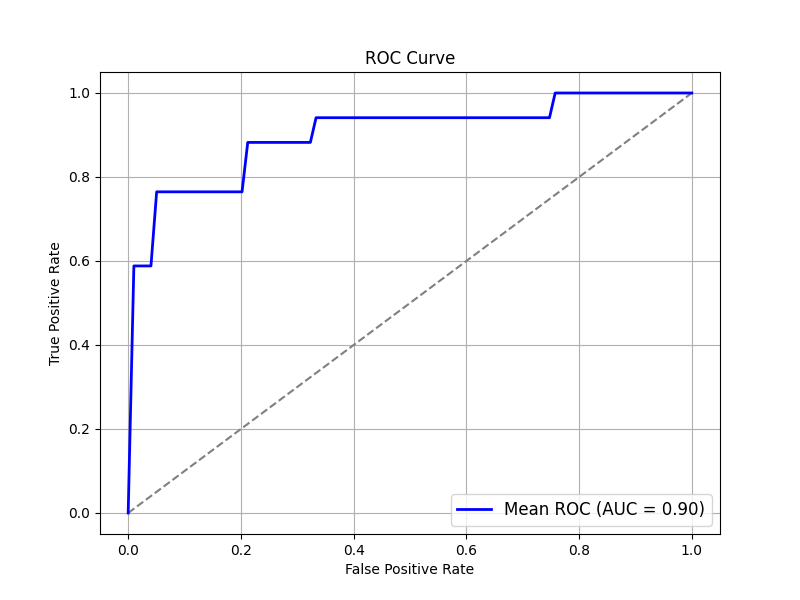

### Con PCA

#### Per K

(K: 1 of 3)  (K: 2 of 3)  (K: 3 of 3)
Accuracy        0.785714     0.571429     0.846154
Sensitivity     0.600000     0.333333     1.000000
Specificity     0.888889     1.000000     0.800000
FP              0.111111     0.000000     0.200000
FN              0.400000     0.666667     0.000000

#### Mediati

Avg       Std
Accuracy     0.734432  0.117872
Sensitivity  0.644444  0.273974
Specificity  0.896296  0.081817
FN           0.355556  0.273974
FP           0.103704  0.081817

### Confusion Matrix:

Predicted P  Predicted N
Actual P     0.644444     0.355556
Actual N     0.103704     0.896296

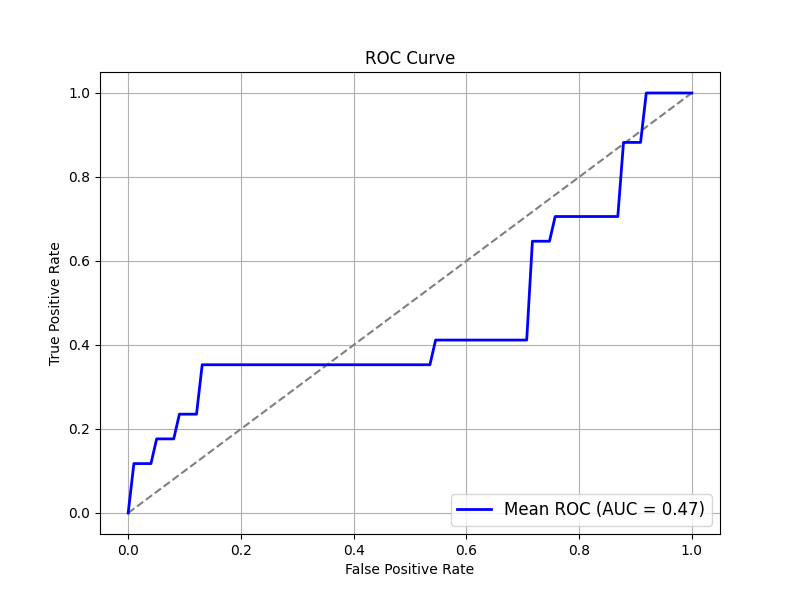

{'fpr': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.7272727

In [ ]:
pd.options.display.float_format = None

results_SVM, prob_pred_SVM, models_SVM = ML.train_test(ML_models['SVM'], fd)
pc_results_SVM, pc_prob_pred_SVM, pc_models_SVM = pc_ML.train_test(pc_ML_models['SVM'], fd)

jupyprint('### Senza PCA')
jupyprint('#### Per K')
ML.table_kfolds(results_SVM)
jupyprint('#### Mediati')
avg_results_SVM = ML.avg_std_kfolds(results_SVM, table=True)
ML.confusion_matrix(avg_results_SVM)
ML.ROC_curve()

jupyprint('### Con PCA')
jupyprint('#### Per K')
pc_ML.table_kfolds(pc_results_SVM)
jupyprint('#### Mediati')
pc_avg_results_SVM = pc_ML.avg_std_kfolds(pc_results_SVM, table=True)
pc_ML.confusion_matrix(pc_avg_results_SVM)
pc_ML.ROC_curve()

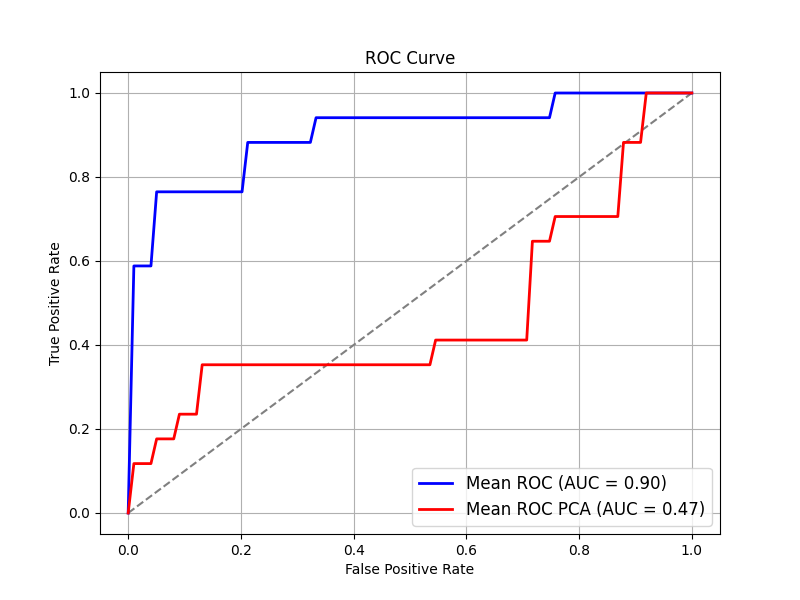

In [ ]:
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
fpr, tpr, _ = roc_curve(labels_int, prob_pred_SVM)
tprs.append(np.interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

pc_tprs = []
pc_aucs = []
fpr, tpr, _ = roc_curve(labels_int, pc_prob_pred_SVM)
pc_tprs.append(np.interp(mean_fpr, fpr, tpr))
pc_tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
pc_aucs.append(roc_auc)

pc_mean_tpr = np.mean(pc_tprs, axis=0)
pc_mean_auc = auc(mean_fpr, pc_mean_tpr)

# Disegna la curva ROC media
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
plt.plot(mean_fpr, pc_mean_tpr, color='r', label=f'Mean ROC PCA (AUC = {pc_mean_auc:.2f})', lw=2)

# Imposta le etichette e la legenda
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right', fontsize = 'large')
plt.grid()
plt.show()


## **Random Forest [Training + Testing]**

k = 3
k = 3


### Senza PCA

#### Per K

(K: 1 of 3)  (K: 2 of 3)  (K: 3 of 3)
Accuracy        0.857143     0.785714          1.0
Sensitivity     1.000000     0.666667          1.0
Specificity     0.777778     1.000000          1.0
FP              0.222222     0.000000          0.0
FN              0.000000     0.333333          0.0

#### Mediati

Avg       Std
Accuracy     0.880952  0.089087
Sensitivity  0.888889  0.157135
Specificity  0.925926  0.104757
FN           0.111111  0.157135
FP           0.074074  0.104757

### Confusion Matrix:

Predicted P  Predicted N
Actual P     0.888889     0.111111
Actual N     0.074074     0.925926

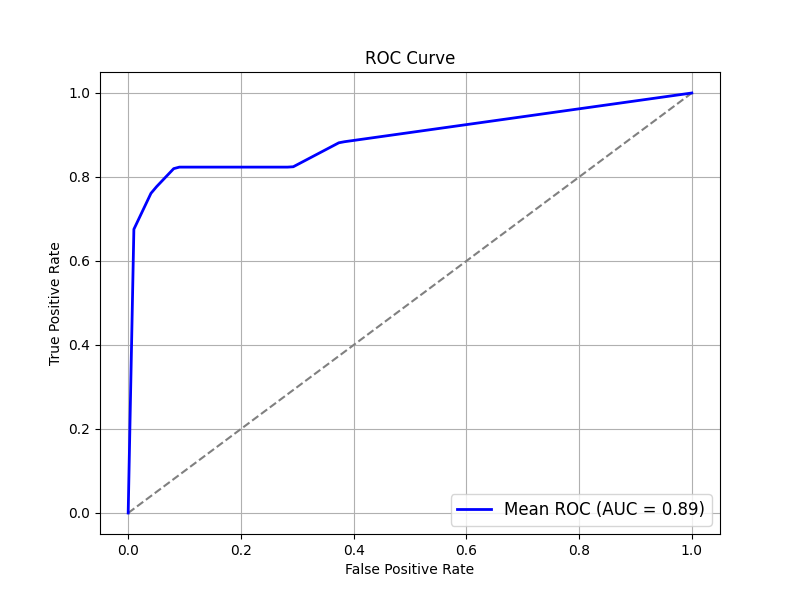

### Con PCA

#### Per K

(K: 1 of 3)  (K: 2 of 3)  (K: 3 of 3)
Accuracy        0.500000     0.642857     0.538462
Sensitivity     0.600000     0.444444     0.666667
Specificity     0.444444     1.000000     0.500000
FP              0.555556     0.000000     0.500000
FN              0.400000     0.555556     0.333333

#### Mediati

Avg       Std
Accuracy     0.560440  0.060356
Sensitivity  0.570370  0.093110
Specificity  0.648148  0.249828
FN           0.429630  0.093110
FP           0.351852  0.249828

### Confusion Matrix:

Predicted P  Predicted N
Actual P     0.570370     0.429630
Actual N     0.351852     0.648148

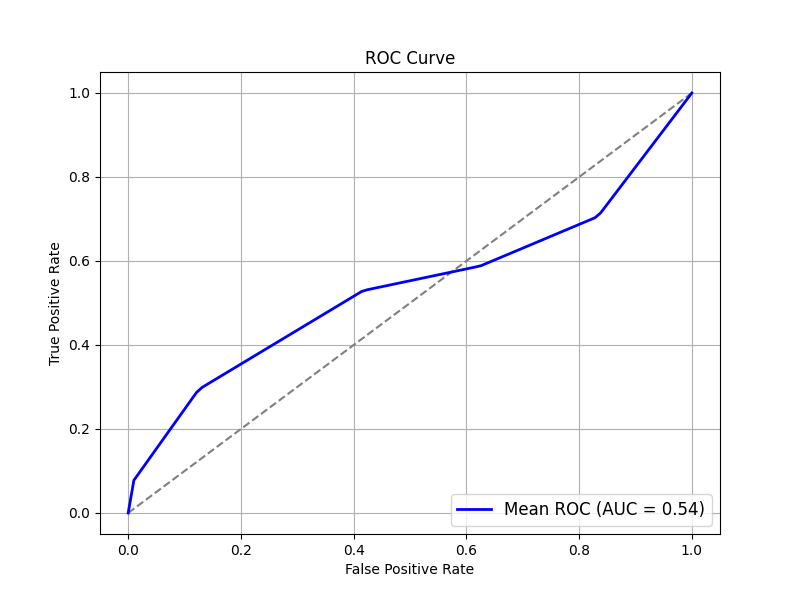

{'fpr': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.7272727

In [ ]:
results_RF, prob_pred_RF, models_RF = ML.train_test(ML_models['Random Forest'], fd)
pc_results_RF, pc_prob_pred_RF, pc_models_RF = pc_ML.train_test(pc_ML_models['Random Forest'], fd)

jupyprint('### Senza PCA')
jupyprint('#### Per K')
ML.table_kfolds(results_RF)
jupyprint('#### Mediati')
avg_results_RF = ML.avg_std_kfolds(results_RF, table=True)
ML.confusion_matrix(avg_results_RF)
ML.ROC_curve()

jupyprint('### Con PCA')
jupyprint('#### Per K')
pc_ML.table_kfolds(pc_results_RF)
jupyprint('#### Mediati')
pc_avg_results_RF = pc_ML.avg_std_kfolds(pc_results_RF, table=True)
pc_ML.confusion_matrix(pc_avg_results_RF)
pc_ML.ROC_curve()

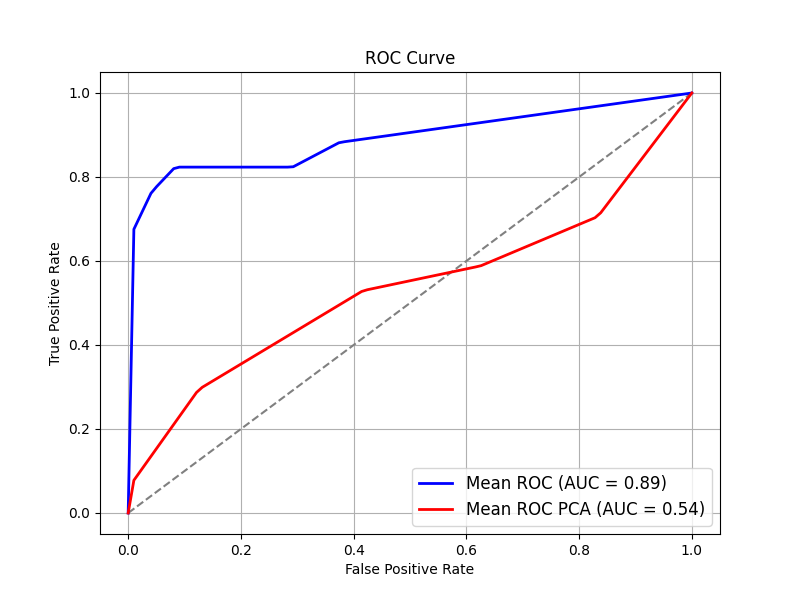

In [ ]:
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
fpr, tpr, _ = roc_curve(labels_int, prob_pred_RF)
tprs.append(np.interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

pc_tprs = []
pc_aucs = []
fpr, tpr, _ = roc_curve(labels_int, pc_prob_pred_RF)
pc_tprs.append(np.interp(mean_fpr, fpr, tpr))
pc_tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
pc_aucs.append(roc_auc)

pc_mean_tpr = np.mean(pc_tprs, axis=0)
pc_mean_auc = auc(mean_fpr, pc_mean_tpr)

# Disegna la curva ROC media
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
plt.plot(mean_fpr, pc_mean_tpr, color='r', label=f'Mean ROC PCA (AUC = {pc_mean_auc:.2f})', lw=2)

# Imposta le etichette e la legenda
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right', fontsize = 'large')
plt.grid()
plt.show()

## Analisi statistica

Analisi per diversi K e numero di alberi fissato.
Fissato il K, si ripete il folding e il training di entrambi i modelli. I risultati delle metriche vengono salvati e mediati.



In [ ]:
def stat_an(N_as, k1, k2, ML):
  dk = k2-k1
  accuracy = np.array([[],[]])
  sensitivity = np.array([[],[]])
  specificity = np.array([[],[]])
  FP = np.array([[],[]])
  FN = np.array([[],[]])


  ACCU      = np.zeros((dk,2))
  ACCU_err  = np.zeros((dk,2))
  SENS      = np.zeros((dk,2))
  SENS_err  = np.zeros((dk,2))
  SPEC      = np.zeros((dk,2))
  SPEC_err  = np.zeros((dk,2))
  FAPO      = np.zeros((dk,2))
  FAPO_err  = np.zeros((dk,2))
  FANE      = np.zeros((dk,2))
  FANE_err  = np.zeros((dk,2))

  for k in range(k1,k2):
    for i in range(N_as):
      fd_as = ML.data_folding(k)
      results_as_S, prob_pred_S, models_as_S = ML.train_test(ML_models['SVM'], folding = fd_as, kappa = False)
      results_as_R, prob_pred_R, models_as_R = ML.train_test(ML_models['Random Forest'], folding = fd_as, kappa = False)

      accuracy    = np.column_stack((accuracy, np.array([results_as_S['Accuracy'], results_as_R['Accuracy']])))
      sensitivity = np.column_stack((sensitivity, np.array([results_as_S['Sensitivity'], results_as_R['Sensitivity']])))
      specificity = np.column_stack((specificity, np.array([results_as_S['Specificity'], results_as_R['Specificity']])))
      FP          = np.column_stack((FP, np.array([results_as_S['FP'], results_as_R['FP']])))
      FN          = np.column_stack((FN, np.array([results_as_S['FN'], results_as_R['FN']])))

    ACCU[k-k1] = np.mean(accuracy, axis = 1)
    ACCU_err[k-k1] = np.std(accuracy, axis = 1)

    SENS[k-k1] = np.mean(sensitivity, axis = 1)
    SENS_err[k-k1] = np.std(sensitivity, axis = 1)

    SPEC[k-k1] = np.mean(specificity, axis = 1)
    SPEC_err[k-k1] = np.std(specificity, axis = 1)

    FAPO[k-k1] = np.mean(FP, axis = 1)
    FAPO_err[k-k1] = np.std(FP, axis = 1)

    FANE[k-k1] = np.mean(FN, axis = 1)
    FANE_err[k-k1] = np.std(FN, axis = 1)

  return {'accu':   ACCU,
        'accu_err': ACCU_err,
        'sens':     SENS,
        'sens_err': SENS_err,
        'spec':     SPEC,
        'spec_err': SPEC_err,
        'fapo':     FAPO,
        'fapo_err': FAPO_err,
        'fane':     FANE,
        'fane_err': FANE_err}

In [ ]:
def plottaplotta(avgs, k1, k2, Legend):

  ACCU      = avgs['accu']
  ACCU_err  = avgs['accu_err']
  SENS      = avgs['sens']
  SENS_err  = avgs['sens_err']
  SPEC      = avgs['spec']
  SPEC_err  = avgs['spec_err']
  FAPO      = avgs['fapo']
  FAPO_err  = avgs['fapo_err']
  FANE      = avgs['fane']
  FANE_err  = avgs['fane_err']

  def plottami(x, y, y_err, title, legend):
    plt.errorbar(x, y, y_err, linestyle='None', marker = 'o', label=legend)
    plt.title(title)
    plt.grid()
    plt.xlabel('K')

  # plt.figure(figsize=(18, 8))
  plt.subplot(2, 5, 1)
  plottami(range(k1,k2), ACCU[:,0], ACCU_err[:,0],'Accuracy', Legend)
  ax_1 = plt.subplot(2, 5, 6)
  plottami(range(k1,k2), ACCU[:,1], ACCU_err[:,1],'Accuracy', Legend)

  plt.subplot(2, 5, 2)
  plottami(range(k1,k2), SENS[:,0], SENS_err[:,0],'Sensitivity', Legend)
  plt.subplot(2, 5, 7)
  plottami(range(k1,k2), SENS[:,1], SENS_err[:,1],'Sensitivity', Legend)

  plt.subplot(2, 5, 3)
  plottami(range(k1,k2), SPEC[:,0], SPEC_err[:,0],'Specificity', Legend)
  plt.subplot(2, 5, 8)
  plottami(range(k1,k2), SPEC[:,1], SPEC_err[:,1],'Specificity', Legend)

  plt.subplot(2, 5, 4)
  plottami(range(k1,k2), FAPO[:,0], FAPO_err[:,0],'False positive', Legend)
  plt.subplot(2, 5, 9)
  plottami(range(k1,k2), FAPO[:,1], FAPO_err[:,1],'False positive', Legend)

  plt.subplot(2, 5, 5)
  plottami(range(k1,k2), FANE[:,0], FANE_err[:,0],'False negative', Legend)
  plt.subplot(2, 5, 10)
  plottami(range(k1,k2), FANE[:,1], FANE_err[:,1],'False negative', Legend)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.subplots_adjust(top=0.85, hspace=0.5, wspace=0.3)

In [ ]:
stat_an_flag = False

if stat_an_flag:
  N_as = 40
  k1 = 2
  k2 = 6

  # dataset originale
  avgs_data = stat_an(N_as, k1, k2, ML)

  # dataset loggato
  avgs_log = stat_an(N_as, k1, k2, ML_log)

  # dataset PCA
  pc_avgs = stat_an(N_as, k1, k2, pc_ML)

In [ ]:
if stat_an_flag:
  plt.figure(figsize=(18, 8))
  plottaplotta(avgs_data, k1, k2, Legend = 'original')
  plottaplotta(avgs_log, k1, k2, Legend = 'Lognormalized')
  plottaplotta(pc_avgs, k1, k2, Legend = 'PCA')
  plt.grid()
  plt.show()

## Outlier

Abbiamo feature distribuite normalmente e feature distribuite lognormalmente, per scalarle bene dobbiamo fare attenzione perchè lo scaler assume che siano distribuite normalmente. Dovremmo passare sotto logaritmo le feature lognormali e ottenere quindi solo featue distrivuite normalmente. Allora possiamo scalare tutto con lo stesso scaler.

### NO PCA, NO LOG

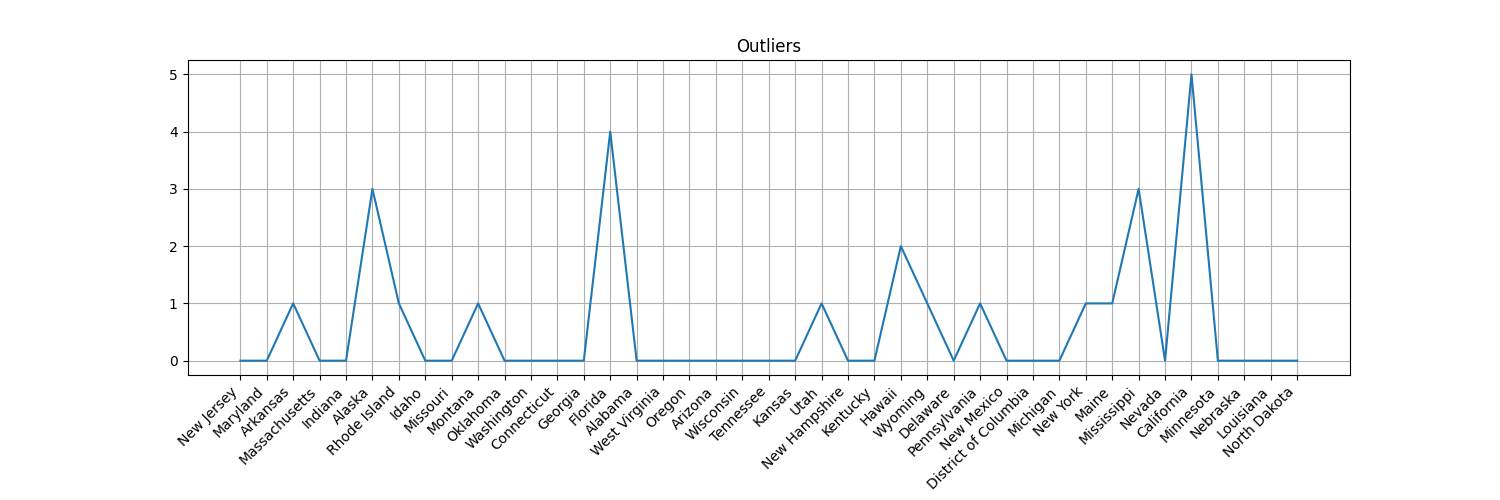

In [ ]:
scaler = StandardScaler()
scaled_data_int = scaler.fit_transform(data_int)

# Ottengomo medie e deviazioni standard feature scalate
#
# feature_means = scaler.mean_
# feature_std = np.sqrt(scaler.var_)

outlier = np.zeros(len(scaled_data_int))

for i, state in enumerate(scaled_data_int):
    outlier[i] = 0
    for j, feat in enumerate(state):
        if np.abs(feat) > 2:
            outlier[i] += 1

# Visualizza outliers
plt.figure(figsize=(15, 5))
plt.title(f'Outliers')
plt.subplots_adjust(bottom=0.25)
plt.xticks(range(0,len(scaled_data_int)), state_names_int, rotation=45, ha='right')
plt.plot(outlier)
plt.grid()
plt.show()

In [ ]:
# Percentuale feature outlier per essere considerato outlier
p_outlier = 0.3

# Vettore che mi indica la posizione degli outlier
outlier_idx = np.zeros(len(outlier))

for i in range(len(outlier)) :
  if outlier[i] > p_outlier * len(scaled_data_int[0]) :
    outlier_idx[i] = 1

outlier_idx = np.array(outlier_idx, dtype=bool)

out_data_int = np.delete(data_int, outlier_idx, axis=0)
out_labels_int = np.delete(labels_int, outlier_idx, axis=0)

# Modelli
out_ML = ABC123(out_data_int, out_labels_int)

out_fd = out_ML.data_folding(K, show_kfold = True)

out_ML_models = {'SVM': SVC(kernel='linear', C=2, probability=True), 'Random Forest': RFC(n_estimators = n_est, criterion = 'gini')}

### Indici delle fold associate a ciascun campione:

$\begin{bmatrix}{} 0 & 2 & 2 & 2 & 0 & 0 & 1 & 0 & 2 & 0 & 1 & 2 & 2 & 1 & 1 & 2 & 1 & 1 & 0 & 0 & 1 & 1 & 1 & 0 & 2 & 0 & 2 & 2 & 1 & 2 & 0 & 2 & 2 & 0 & 0 & 1 & 0 & 0 & 1 & 1 \end{bmatrix}$

### SVM

k = 3


#### Per K

(K: 1 of 3)  (K: 2 of 3)  (K: 3 of 3)
Accuracy        0.857143          1.0          1.0
Sensitivity     0.750000          1.0          1.0
Specificity     0.900000          1.0          1.0
FP              0.100000          0.0          0.0
FN              0.250000          0.0          0.0

#### Mediati

Avg       Std
Accuracy     0.952381  0.067344
Sensitivity  0.916667  0.117851
Specificity  0.966667  0.047140
FN           0.083333  0.117851
FP           0.033333  0.047140

### Confusion Matrix:

Predicted P  Predicted N
Actual P     0.916667     0.083333
Actual N     0.033333     0.966667

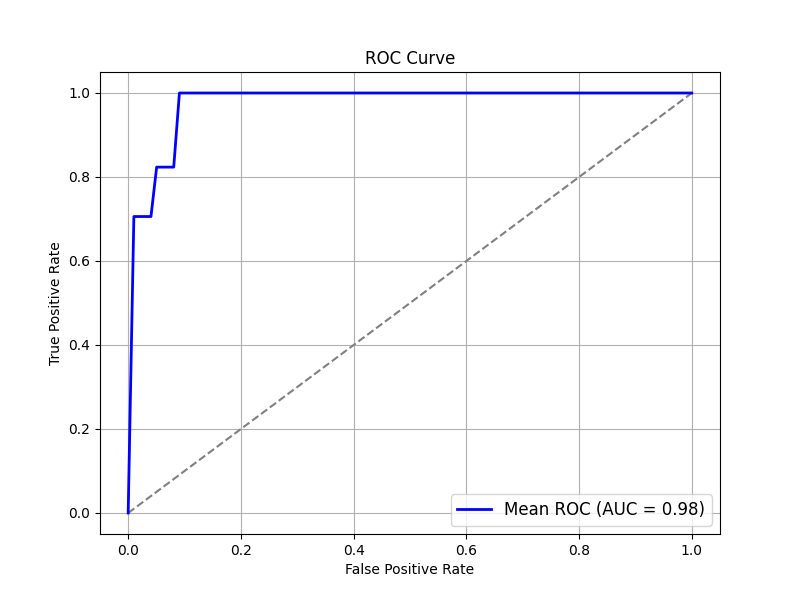

### Random Forest

k = 3


#### Per K

(K: 1 of 3)  (K: 2 of 3)  (K: 3 of 3)
Accuracy        0.857143     0.769231          1.0
Sensitivity     0.750000     0.571429          1.0
Specificity     0.900000     1.000000          1.0
FP              0.100000     0.000000          0.0
FN              0.250000     0.428571          0.0

#### Mediati

Avg       Std
Accuracy     0.875458  0.095097
Sensitivity  0.773810  0.175772
Specificity  0.966667  0.047140
FN           0.226190  0.175772
FP           0.033333  0.047140

### Confusion Matrix:

Predicted P  Predicted N
Actual P     0.773810     0.226190
Actual N     0.033333     0.966667

{'fpr': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.7272727

In [ ]:
pd.options.display.float_format = None

jupyprint('### SVM')

results_out, prob_pred_out, models_out_S = out_ML.train_test(out_ML_models['SVM'], out_fd)

jupyprint('#### Per K')
out_ML.table_kfolds(results_out)
jupyprint('#### Mediati')
avg_results_out = out_ML.avg_std_kfolds(results_out, table=True)
out_ML.confusion_matrix(avg_results_out)
out_ML.ROC_curve()

jupyprint('### Random Forest')

results_out, prob_pred_out, models_out_RF = out_ML.train_test(out_ML_models['Random Forest'], out_fd)

jupyprint('#### Per K')
out_ML.table_kfolds(results_out)
jupyprint('#### Mediati')
avg_results_out = out_ML.avg_std_kfolds(results_out, table=True)
out_ML.confusion_matrix(avg_results_out)
out_ML.ROC_curve()

### PCA, NO LOG

In [ ]:
scaler = StandardScaler()
scaled_data_int = scaler.fit_transform(pc_data_int)

# Ottengomo medie e deviazioni standard feature scalate
#
# feature_means = scaler.mean_
# feature_std = np.sqrt(scaler.var_)

outlier_pc = np.zeros(len(scaled_data_int))

for i, state in enumerate(scaled_data_int):
    outlier_pc[i] = 0
    for j, feat in enumerate(state):
        if np.abs(feat) > 2:
            outlier_pc[i] += 1

# Visualizza outliers
plt.figure(figsize=(15, 5))
plt.title(f'Outliers, PCA')
plt.subplots_adjust(bottom=0.25)
plt.xticks(range(0,len(scaled_data_int)), state_names_int, rotation=45, ha='right')
plt.plot(outlier_pc)
plt.grid()
plt.show()

In [ ]:
# Percentuale feature outlier per essere considerato outlier
p_outlier = 0.3

# Vettore che mi indica la posizione degli outlier
outlier_idx = np.zeros(len(outlier_pc))

for i in range(len(outlier)) :
  if outlier_pc[i] > p_outlier * len(scaled_data_int[0]) :
    outlier_idx[i] = 1

outlier_idx = np.array(outlier_idx, dtype=bool)

out_data_int = np.delete(pc_data_int, outlier_idx, axis=0)
out_labels_int = np.delete(labels_int, outlier_idx, axis=0)

# Modelli
outP_ML = ABC123(out_data_int, out_labels_int)

outP_fd = outP_ML.data_folding(K, show_kfold = True)

outP_ML_models = {'SVM': SVC(kernel='linear', C=2, probability=True), 'Random Forest': RFC(n_estimators = n_est, criterion = 'gini')}

### Indici delle fold associate a ciascun campione:

$\begin{bmatrix}{} 1 & 0 & 2 & 0 & 0 & 1 & 1 & 0 & 1 & 0 & 2 & 1 & 0 & 2 & 1 & 1 & 0 & 1 & 2 & 2 & 1 & 2 & 2 & 1 & 0 & 2 & 0 & 2 & 0 & 2 & 2 & 1 & 0 & 1 & 0 & 2 & 1 & 0 \end{bmatrix}$

In [ ]:
pd.options.display.float_format = None

jupyprint('### SVM')

results_out, prob_pred_out, models_out_pc_S = outP_ML.train_test(outP_ML_models['SVM'], outP_fd)

jupyprint('#### Per K')
outP_ML.table_kfolds(results_out)
jupyprint('#### Mediati')
avg_results_out = outP_ML.avg_std_kfolds(results_out, table=True)
outP_ML.confusion_matrix(avg_results_out)
outP_ML.ROC_curve()

jupyprint('### Random Forest')

results_out, prob_pred_out, models_out_pc_RF = outP_ML.train_test(outP_ML_models['Random Forest'], outP_fd)

jupyprint('#### Per K')
outP_ML.table_kfolds(results_out)
jupyprint('#### Mediati')
avg_results_out = outP_ML.avg_std_kfolds(results_out, table=True)
outP_ML.confusion_matrix(avg_results_out)
outP_ML.ROC_curve()

### SVM

k = 3


#### Per K

(K: 1 of 3)  (K: 2 of 3)  (K: 3 of 3)
Accuracy        0.461538     0.692308         0.75
Sensitivity     0.285714     0.666667         0.75
Specificity     0.666667     0.714286         0.75
FP              0.333333     0.285714         0.25
FN              0.714286     0.333333         0.25

#### Mediati

Avg       Std
Accuracy     0.634615  0.124630
Sensitivity  0.567460  0.202108
Specificity  0.710317  0.034136
FN           0.432540  0.202108
FP           0.289683  0.034136

### Confusion Matrix:

Predicted P  Predicted N
Actual P     0.567460     0.432540
Actual N     0.289683     0.710317

/content/drive/MyDrive/ML-Colab/myClassROC.py:235: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


### Random Forest

k = 3


#### Per K

(K: 1 of 3)  (K: 2 of 3)  (K: 3 of 3)
Accuracy        0.538462     0.461538     0.416667
Sensitivity     0.428571     0.333333     0.750000
Specificity     0.666667     0.571429     0.250000
FP              0.333333     0.428571     0.750000
FN              0.571429     0.666667     0.250000

#### Mediati

Avg       Std
Accuracy     0.472222  0.050293
Sensitivity  0.503968  0.178263
Specificity  0.496032  0.178263
FN           0.496032  0.178263
FP           0.503968  0.178263

### Confusion Matrix:

Predicted P  Predicted N
Actual P     0.503968     0.496032
Actual N     0.503968     0.496032

{'fpr': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.7272727

### NO PCA, LOG

In [ ]:
# Per dati log
scaler = StandardScaler()
scaled_ldata_int = scaler.fit_transform(log_data_int)

outlier_l = np.zeros(len(scaled_ldata_int))

for i, state in enumerate(scaled_ldata_int):
    outlier_l[i] = 0
    for j, feat in enumerate(state):
        if np.abs(feat) > 2:
            outlier_l[i] += 1

# Visualizza outliers
plt.figure(figsize=(15, 5))
plt.title(f'Outliers')
plt.subplots_adjust(bottom=0.25)
plt.xticks(range(0,len(scaled_ldata_int)), state_names_int, rotation=45, ha='right')
plt.plot(outlier_l)
plt.grid()
plt.show()

In [ ]:
# Percentuale feature outlier per essere considerato outlier
p_outlier = 0.3

# Vettore che mi indica la posizione degli outlier
outlier_idx = np.zeros(len(outlier))

for i in range(len(outlier)) :
  if outlier[i] > p_outlier * len(scaled_data_int[0]) :
    outlier_idx[i] = 1

outlier_idx = np.array(outlier_idx, dtype=bool)

out_data_int = np.delete(log_data_int, outlier_idx, axis=0)
out_labels_int = np.delete(labels_int, outlier_idx, axis=0)

# Modelli
outL_ML = ABC123(out_data_int, out_labels_int)

outL_fd = outL_ML.data_folding(K, show_kfold = True)

outL_ML_models = {'SVM': SVC(kernel='linear', C=2, probability=True), 'Random Forest': RFC(n_estimators = n_est, criterion = 'gini')}

### Indici delle fold associate a ciascun campione:

$\begin{bmatrix}{} 2 & 2 & 2 & 2 & 1 & 1 & 0 & 0 & 1 & 1 & 2 & 0 & 0 & 1 & 2 & 0 & 1 & 2 & 2 & 0 & 2 & 1 & 2 & 0 & 1 & 0 & 2 & 2 & 1 & 1 & 0 & 0 & 0 & 1 & 0 & 1 \end{bmatrix}$

### SVM

k = 3


#### Per K

(K: 1 of 3)  (K: 2 of 3)  (K: 3 of 3)
Accuracy        0.916667          1.0     0.916667
Sensitivity     0.833333          1.0     1.000000
Specificity     1.000000          1.0     0.857143
FP              0.000000          0.0     0.142857
FN              0.166667          0.0     0.000000

#### Mediati

Avg       Std
Accuracy     0.944444  0.039284
Sensitivity  0.944444  0.078567
Specificity  0.952381  0.067344
FN           0.055556  0.078567
FP           0.047619  0.067344

### Confusion Matrix:

Predicted P  Predicted N
Actual P     0.944444     0.055556
Actual N     0.047619     0.952381

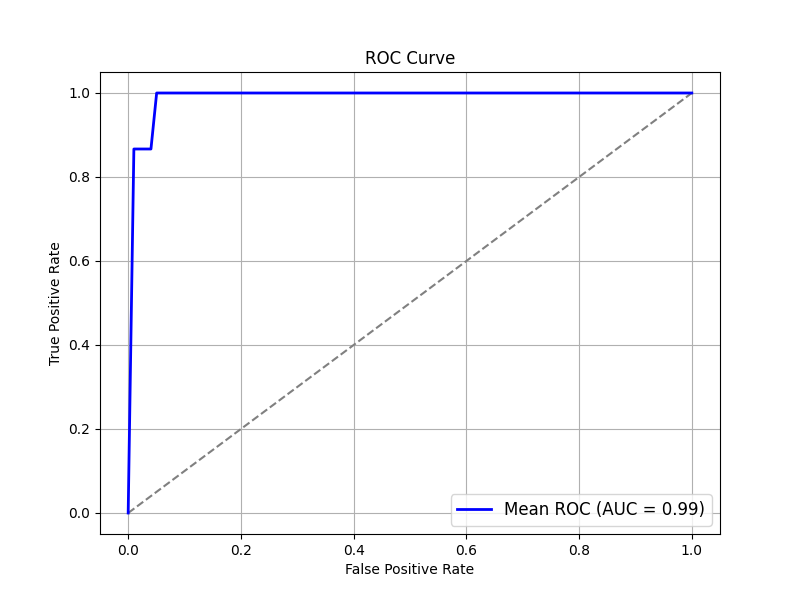

### Random Forest

k = 3


#### Per K

(K: 1 of 3)  (K: 2 of 3)  (K: 3 of 3)
Accuracy        0.916667     0.916667          1.0
Sensitivity     0.833333     1.000000          1.0
Specificity     1.000000     0.875000          1.0
FP              0.000000     0.125000          0.0
FN              0.166667     0.000000          0.0

#### Mediati

Avg       Std
Accuracy     0.944444  0.039284
Sensitivity  0.944444  0.078567
Specificity  0.958333  0.058926
FN           0.055556  0.078567
FP           0.041667  0.058926

### Confusion Matrix:

Predicted P  Predicted N
Actual P     0.944444     0.055556
Actual N     0.041667     0.958333

{'fpr': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.7272727

In [ ]:
pd.options.display.float_format = None

jupyprint('### SVM')

results_out, prob_pred_out, models_out_log_S = outL_ML.train_test(outL_ML_models['SVM'], outL_fd)

jupyprint('#### Per K')
outL_ML.table_kfolds(results_out)
jupyprint('#### Mediati')
avg_results_out = outL_ML.avg_std_kfolds(results_out, table=True)
outL_ML.confusion_matrix(avg_results_out)
outL_ML.ROC_curve()

jupyprint('### Random Forest')

results_out, prob_pred_out, models_out_log_RF = outL_ML.train_test(outL_ML_models['Random Forest'], outL_fd)

jupyprint('#### Per K')
outL_ML.table_kfolds(results_out)
jupyprint('#### Mediati')
avg_results_out = outL_ML.avg_std_kfolds(results_out, table=True)
outL_ML.confusion_matrix(avg_results_out)
outL_ML.ROC_curve()

### Analisi statistica outlier

In [ ]:
if stat_an_flag:
  N_as = 40
  k1 = 2
  k2 = 6

  # dataset originale outlier
  avgs_dout = stat_an(N_as, k1, k2, out_ML)

  # dataset PCA outlier
  pc_out_avgs = stat_an(N_as, k1, k2, outP_ML)

In [ ]:
if stat_an_flag:
  plt.figure(figsize=(18, 8))
  plottaplotta(avgs_data, k1, k2, Legend = 'original')
  plottaplotta(avgs_dout, k1, k2, Legend = 'original outlier')
  plottaplotta(pc_avgs, k1, k2, Legend = 'PCA')
  plottaplotta(pc_out_avgs, k1, k2, Legend = 'PCA outlier')
  plt.grid()
  plt.show()

## Testing esterno

In [ ]:
jupyprint(pd.DataFrame(data_ext, index = state_names_ext, columns = features))

Centroid Longitude  Centroid Latitude  \
Vermont                 -72.556496          44.043498   
Ohio                    -82.662996          40.217482   
Virginia                -78.949416          37.546013   
Texas                   -99.209698          30.515779   
Colorado               -105.543955          39.029532   
Illinois                -89.198000          39.742374   
North Carolina          -79.052731          35.627245   
South Carolina          -81.245037          33.810122   
Iowa                    -93.762335          42.132789   
South Dakota            -99.678970          44.272030   

                Licensed drivers (thousands)  Registered vehicles (thousands)  \
Vermont                              550.462                          551.516   
Ohio                                7675.007                        10934.942   
Virginia                            5112.523                         6572.883   
Texas                              14543.528                        17193.706   
Colorado                            3205.054                         2031.703   
Illinois                            8057.683                         9507.663   
North Carolina                      6122.137                         6298.836   
South Carolina                      2972.369                         3317.101   
Iowa                                2003.723                         3509.431   
South Dakota                         563.298                          882.769   

                Vehicle-miles traveled (millions)  Miles traveled per vehicle  \
Vermont                                    7855.0                14242.560506   
Ohio                                     111654.0                10210.753747   
Virginia                                  78877.0                12000.365745   
Texas                                    231008.0                13435.614172   
Colorado                                  45891.0                22587.454958   
Illinois                                 109135.0                11478.635707   
North Carolina                            95903.0                15225.511507   
South Carolina                            49551.0                14938.043792   
Iowa                                      31538.0                 8986.641994   
South Dakota                               8784.0                 9950.508004   

                Fatalities per 100K licensed drivers  \
Vermont                                    17.803227   
Ohio                                       16.755685   
Virginia                                   18.092828   
Texas                                      24.636388   
Colorado                                   20.748480   
Illinois                                   16.828659   
North Carolina                             25.432296   
South Carolina                             35.190786   
Iowa                                       19.463768   
South Dakota                               34.972608   

                Fatalities per 100K registered vehicles  \
Vermont                                       17.769203   
Ohio                                          11.760465   
Virginia                                      14.072972   
Texas                                         20.839021   
Colorado                                      32.731162   
Illinois                                      14.262180   
North Carolina                                24.718853   
South Carolina                                31.533559   
Iowa                                          11.112913   
South Dakota                                  22.316144   

                Fatalities per 100M vehicle-miles traveled  \
Vermont                                           1.247613   
Ohio                                              1.151772   
Virginia                                          1.172712   
Texas                                             1.551029   
Colorado                   

In [ ]:
modelli = [models_SVM, pc_models_SVM, models_RF, pc_models_RF, models_out_S, models_out_RF, models_out_pc_S, models_out_pc_RF, models_out_log_S, models_out_log_RF]
data = [data_ext, pc_data_ext, data_ext, pc_data_ext, data_ext, data_ext, pc_data_ext, pc_data_ext, log_data_ext, log_data_ext]
title = ['## SVM', '## SVM con PCA', '## Random Forest', '## Random Forest con PCA', '## SVM outlier', '## Random Forest outlier', '## SVM outlier con PCA', '## Random Forest outlier con PCA', '## SVM outlier con log', '## Random Forest outlier con log']

for i in range(len(modelli)):
  results_E = ML.external_testing(modelli[i], data[i], labels_ext)

  jupyprint(title[i])
  print('\nAccuracy         : ', results_E['Accuracy'])
  print('\nSensitivity      : ', results_E['Sensitivity'])
  print('\nSpecificity      : ', results_E['Specificity'])
  print('\nFalse positive   : ', results_E['FP'])
  print('\nFalse Negative   : ', results_E['FN'])
  print('------------------------------------------------')

## SVM


Accuracy         :  0.6

Sensitivity      :  0.0

Specificity      :  0.857142857142857

False positive   :  0.14285714285714285

False Negative   :  1.0
------------------------------------------------


## SVM con PCA


Accuracy         :  0.7

Sensitivity      :  0.3333333333333333

Specificity      :  0.857142857142857

False positive   :  0.14285714285714285

False Negative   :  0.6666666666666666
------------------------------------------------


## Random Forest


Accuracy         :  0.30000000000000004

Sensitivity      :  1.0

Specificity      :  0.0

False positive   :  0.9999999999999998

False Negative   :  0.0
------------------------------------------------


## Random Forest con PCA


Accuracy         :  0.7

Sensitivity      :  0.0

Specificity      :  0.9999999999999998

False positive   :  0.0

False Negative   :  1.0
------------------------------------------------


## SVM outlier


Accuracy         :  0.7

Sensitivity      :  0.0

Specificity      :  0.9999999999999998

False positive   :  0.0

False Negative   :  1.0
------------------------------------------------


## Random Forest outlier


Accuracy         :  0.30000000000000004

Sensitivity      :  1.0

Specificity      :  0.0

False positive   :  0.9999999999999998

False Negative   :  0.0
------------------------------------------------


## SVM outlier con PCA


Accuracy         :  0.30000000000000004

Sensitivity      :  1.0

Specificity      :  0.0

False positive   :  0.9999999999999998

False Negative   :  0.0
------------------------------------------------


## Random Forest outlier con PCA


Accuracy         :  0.30000000000000004

Sensitivity      :  1.0

Specificity      :  0.0

False positive   :  0.9999999999999998

False Negative   :  0.0
------------------------------------------------


## SVM outlier con log


Accuracy         :  0.7

Sensitivity      :  0.0

Specificity      :  0.9999999999999998

False positive   :  0.0

False Negative   :  1.0
------------------------------------------------


## Random Forest outlier con log


Accuracy         :  0.30000000000000004

Sensitivity      :  1.0

Specificity      :  0.0

False positive   :  0.9999999999999998

False Negative   :  0.0
------------------------------------------------


In [ ]:
accuracy_E = 0.
sensitivity_E = 0.
specificity_E = 0.
FP_E = 0.
FN_E = 0.

N_E = len(data_ext)

for i in range(N_E):
  class_pred_E = 0.
  for j in range(len(modelli)):
    data_E = data[j][i]

    for k in range(len(modelli[j])):
      class_pred_temp_E = modelli[j][str(k)].predict([data_E])
      class_pred_temp_E = class_pred_temp_E.astype(float)
      class_pred_E += class_pred_temp_E[0] / len(modelli[j])

  class_pred_E  = class_pred_E / len(modelli)

  # Caso 0 -> Negative
  if labels_ext[i] == 0 and class_pred_E < .5:
    accuracy_E += 1 / N_E
    specificity_E += 1 / (N_E-np.sum(labels_ext))

  # Caso 1 -> Positive
  if labels_ext[i] == 1 and class_pred_E >= .5:
    accuracy_E += 1 / N_E
    sensitivity_E += 1 / np.sum(labels_ext)

  # Caso 1 -> Negative
  if labels_ext[i] == 1 and class_pred_E < .5:
    FN_E += 1 / np.sum(labels_ext)

  # Caso 0 -> Positive
  if labels_ext[i] == 0 and class_pred_E >= .5:
    FP_E += 1 / (N_E-np.sum(labels_ext))


jupyprint('Totale')
print('\nAccuracy         : ', accuracy_E)
print('\nSensitivity      : ', sensitivity_E)
print('\nSpecificity      : ', specificity_E)
print('\nFalse positive   : ', FP_E)
print('\nFalse Negative   : ', FN_E)
print('------------------------------------------------')

Totale


Accuracy         :  0.7

Sensitivity      :  0.3333333333333333

Specificity      :  0.857142857142857

False positive   :  0.14285714285714285

False Negative   :  0.6666666666666666
------------------------------------------------


## Salvataggio dei parametri associati ai modelli realizzati

In [ ]:
# K, N_trees, data_ext, labels_ext, features, state_names_ext, folding
K, folding_int = fd
with open('parameters.txt','w') as f:
  f.write('K: '+str(K)+'\n')
  f.write('N tree: '+str(3)+'\n')
  f.write('Internal states: '+str(state_names_int.tolist())+'\n')
  f.write('External states: '+str(state_names_ext.tolist())+'\n')
  f.write('External indices: '+str(idx_ext)+'\n')
  f.write('Internal indices: '+str(idx_int)+'\n')
  f.write('Folding: '+str(folding_int.tolist())+'\n')
  f.write('Internal labels: '+str(labels_int.tolist())+'\n')
  f.write('External labels: '+str(labels_ext.tolist())+'\n')
  f.write('Internal dataset: '+str(data_int.tolist())+'\n')
  f.write('External dataset: '+str(data_ext.tolist())+'\n')
  f.write('Features: '+str(features)+'\n')
  f.write('PCA Internal dataset: '+str(pc_data_int.tolist())+'\n')
  f.write('PCA External dataset: '+str(pc_data_ext.tolist())+'\n')

In [ ]:
saving_flag = True

if saving_flag:
  # save
  with open('RF_models.pkl','wb') as f:
      pickle.dump(models_RF,f)
      print('Models saved')
  with open('PCA_RF_models.pkl','wb') as f:
      pickle.dump(pc_models_RF,f)
      print('Models saved')
  with open('SVM_models.pkl','wb') as f:
      pickle.dump(models_SVM,f)
      print('Models saved')
  with open('PCA_SVM_models.pkl','wb') as f:
      pickle.dump(pc_models_SVM,f)
      print('Models saved')
  with open('SVM_out_models.pkl','wb') as f:
      pickle.dump(models_out_S,f)
      print('Models saved')
  with open('RF_out_models.pkl','wb') as f:
      pickle.dump(models_out_RF,f)
      print('Models saved')
  with open('PCA_SVM_out_models.pkl','wb') as f:
      pickle.dump(models_out_pc_S,f)
      print('Models saved')
  with open('PCA_RF_out_models.pkl','wb') as f:
      pickle.dump(models_out_pc_RF,f)
      print('Models saved')
  with open('LOG_SVM_out_models.pkl','wb') as f:
      pickle.dump(models_out_log_S,f)
      print('Models saved')
  with open('LOG_RF_out_models.pkl','wb') as f:
      pickle.dump(models_out_log_RF,f)
      print('Models saved')

  # # load
  # with open('SVM_models.pkl', 'rb') as f:
  #     myModel = pickle.load(f)

  # print(myModel)

Models saved
Models saved
Models saved
Models saved
Models saved
Models saved
Models saved
Models saved
Models saved
Models saved


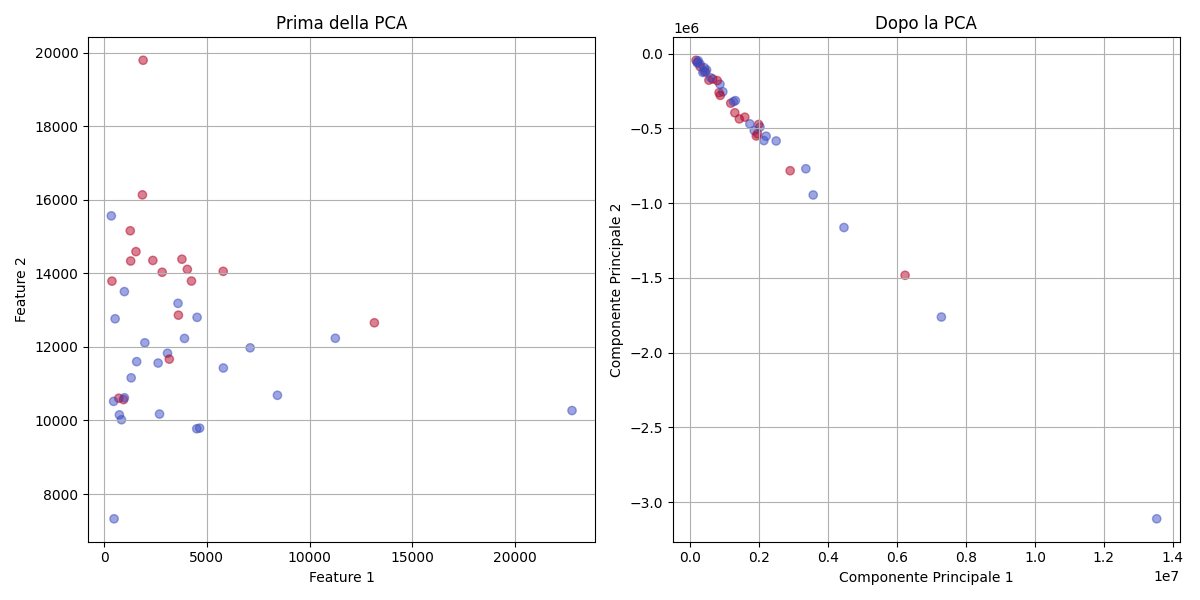

In [ ]:
original_data = data_int
transformed_data = pc_data_int

# Plot prima della PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(original_data[:, 2], original_data[:, 5], c=labels_int, cmap='coolwarm', alpha=0.5)
plt.title('Prima della PCA')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)

# Plot dopo la PCA
plt.subplot(1, 2, 2)
plt.scatter(transformed_data[:, 0], transformed_data[:, 2], c=labels_int, cmap='coolwarm', alpha=0.5)
plt.title('Dopo la PCA')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.grid(True)

plt.tight_layout()
plt.show()